In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Ridge
from scipy import stats
import random
from scipy.stats import sem
import seaborn as sns

# Dataset

In [2]:
jerks_path = "Synthesised_Dataset/Human_Likeness_Features/mean_jerk_values.csv"
XX_jerks = pd.read_csv(jerks_path) # With Spine joint and Name of "Cond/StudySeq"

accels_path = "Synthesised_Dataset/Human_Likeness_Features/mean_acceleration_values.csv"
XX_accels = pd.read_csv(accels_path) # With Spine joint and Name of "Cond/StudySeq"

pairwise_path = "Synthesised_Dataset/Human_Likeness_Features/mean_pairwise_joint_distances.csv"
XX_pairwise = pd.read_csv(pairwise_path) # With Spine joint and Name of "Cond/StudySeq"
XX_pairwise.drop(XX_pairwise.columns[range(1,15)], axis=1, inplace=True) # Without Spine Joint but with Name of "Cond/StudySeq"

labels_path = "Synthesised_Dataset/Human_Likeness_Labels/mean_opinion_scores.csv"
YY = pd.read_csv(labels_path) # # With Name of "Cond/StudySeq"

In [3]:
XY = XX_jerks.join(YY, lsuffix="_jerks", rsuffix="_YY")
XY = XY.join(XX_accels, rsuffix='_accels')
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_accels'})
XY = XY.join(XX_pairwise, rsuffix='_pairwise')
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_pairwise'})

In [4]:
XY = XY.rename(columns={'Unnamed: 0_jerks': 'StudySeq'})
XY['Cond'] = XY['StudySeq'].apply(lambda x: x[:x.index('/')])
XY['StudySeq'] = XY['StudySeq'].apply(lambda x: x[x.index('q')+1:]) # Remove info on Cond
# Drop useless columns
XY.drop(['Unnamed: 0_YY','Unnamed: 0_accels', 'Unnamed: 0_pairwise', 'Spine', 'Spine_accels'], axis=1, inplace=True)
rename_dict = dict(zip(XY.columns[1:15], XY.columns[1:15] + '_jerks'))
XY = XY.rename(columns=rename_dict)

In [5]:
# reorder columns so that Cond and StudySeq are at the start
cols = XY.columns.tolist()
cols.remove('Cond')
cols = ['Cond'] + cols
XY = XY[cols]

In [6]:
XY['StudySeq'] = pd.to_numeric(XY['StudySeq'])
XX = XY.drop(['Mean_Human_Likeness_Score'], axis=1, inplace=False)
bad_features = ['LeftShoulder_vs_LeftArm', 'LeftArm_vs_LeftForeArm', 'LeftForeArm_vs_LeftHand',
                'RightShoulder_vs_RightArm', 'RightArm_vs_RightForeArm','RightForeArm_vs_RightHand']
XX.drop(bad_features, axis=1, inplace=True)
YY = XY[['Cond', 'StudySeq', 'Mean_Human_Likeness_Score']]
XX.iloc[:,2:] = np.log(XX.iloc[:,2:])
print(XX.shape)
print(YY.shape)

(6400, 115)
(6400, 3)


In [7]:
XX.describe()

,StudySeq,Spine1_jerks,Spine2_jerks,Spine3_jerks,LeftShoulder_jerks,LeftArm_jerks,LeftForearm_jerks,LeftHand_jerks,RightShoulder_jerks,RightArm_jerks,...,RightArm_vs_Head,RightForeArm_vs_Neck,RightForeArm_vs_Neck1,RightForeArm_vs_Head,RightHand_vs_Neck,RightHand_vs_Neck1,RightHand_vs_Head,Neck_vs_Neck1,Neck_vs_Head,Neck1_vs_Head
count,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,...,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6.400000e+03,6400.000000,6.400000e+03
mean,400.500000,7.208242,7.346821,7.490371,7.636040,7.801985,8.368183,8.841845,7.636040,7.801985,...,3.177524,3.716474,3.823144,3.930445,3.850601,3.916096,3.992065,1.957319e+00,2.650249,1.957318e+00
std,230.957972,0.729939,0.563583,0.483799,0.440851,0.402712,0.496718,0.473713,0.440851,0.402712,...,0.055437,0.032609,0.030235,0.032359,0.119735,0.128207,0.132573,8.109744e-07,0.000243,4.054875e-07
min,1.000000,3.655330,4.439885,4.900368,5.196570,5.435678,6.282438,6.842470,5.196570,5.435678,...,3.054882,3.622835,3.717854,3.778566,3.413541,3.422816,3.489940,1.957316e+00,2.648701,1.957316e+00
25%,200.750000,7.376003,7.449925,7.549629,7.664474,7.786711,8.053767,8.518593,7.664474,7.786711,...,3.136506,3.698382,3.804306,3.908673,3.777447,3.834709,3.910548,1.957319e+00,2.650196,1.957318e+00
50%,400.500000,7.414342,7.494023,7.600892,7.722766,7.854613,8.220395,8.744846,7.722766,7.854613,...,3.170539,3.715290,3.820779,3.930086,3.861398,3.924632,3.998944,1.957319e+00,2.650326,1.957318e+00
75%,600.250000,7.450067,7.543135,7.662897,7.794366,7.956254,8.641749,9.167548,7.794366,7.956254,...,3.207651,3.734123,3.838101,3.947275,3.923739,3.992616,4.075186,1.957319e+00,2.650402,1.957318e+00
max,800.000000,7.923455,7.936697,8.100524,8.316989,8.586239,9.852115,10.339779,8.316989,8.586239,...,3.338535,3.842823,3.908969,4.022052,4.141571,4.232649,4.318420,1.957319e+00,2.650451,1.957318e+00


107.12149997827633


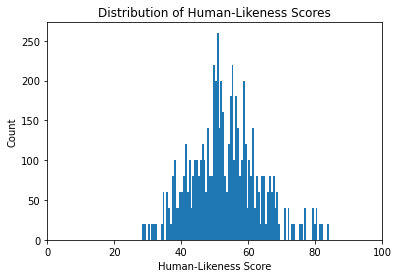

In [8]:
plt.hist(YY['Mean_Human_Likeness_Score'], bins = 100)
plt.xlim(0,100)
plt.xlabel("Human-Likeness Score")
plt.ylabel("Count")
plt.title("Distribution of Human-Likeness Scores")
var = np.var(YY['Mean_Human_Likeness_Score'])
print(var)

# Function Definitions

In [9]:
# studyseqs_to_keep should be a list of the studyseq indexes to keep (e.g. [1,2,3,4....,40] for the original unaugmented data)
def reduce_dataset_size(XX, YY, studyseqs_to_keep):
    reduced_XX = XX[XX['StudySeq'].isin(studyseqs_to_keep)]
    reduced_YY = YY[YY['StudySeq'].isin(studyseqs_to_keep)]
    return reduced_XX, reduced_YY

In [10]:
def split_by_cond(XX, YY, cond_to_split):
    reduced_XX = XX[XX['Cond'].isin([cond_to_split]) == False]
    reduced_YY = YY[YY['Cond'].isin([cond_to_split]) == False]
    cond_XX = XX[XX['Cond'].isin([cond_to_split])]
    cond_YY = YY[YY['Cond'].isin([cond_to_split])]
    return reduced_XX, reduced_YY, cond_XX, cond_YY

In [11]:
def get_rand_studyseqs(duplicates_to_keep):
    iteration = [x for x in range(1,20)]
    random.shuffle(iteration)
    studyseqs_to_keep = [x for x in range(1,41)]
    for i in range(0,duplicates_to_keep):
        start_idx = (iteration[i]*40)+1
        end_idx = ((iteration[i]+1)*40)+1
        studyseqs_to_keep = studyseqs_to_keep + [x for x in range(start_idx,end_idx)] 
    return studyseqs_to_keep

In [12]:
def leave_one_out_folds(XX, YY, conds):
    cv_splits = []
    XX.index = np.arange(0, len(XX))
    for cond in conds:
        train_index = XX[XX['Cond'].isin([cond]) == False].index
        val_index = XX[XX['Cond'].isin([cond])].index[:40] # We don't want to change the validation and test set size with data augmentation
        split = (train_index.to_numpy(), val_index.to_numpy())
        cv_splits = cv_splits + [split]
    return cv_splits

In [13]:
def single_leave_one_out_fold(XX, YY, val_cond):
    train_index = XX[XX['Cond'].isin([val_cond]) == False].index
    val_index = XX[XX['Cond'].isin([val_cond])].index[:40] # We don't want to change the validation and test set size with data augmentation
    cv_split = [(train_index.to_numpy(), val_index.to_numpy())]
    return cv_split

In [14]:
# Performs k-fold cross validation to find the best train set size
def learning_curve(model_name, model, XX, YY, anti_overfit):
    pd.options.mode.chained_assignment = None
    Conds = ['Cond_BA', 'Cond_BT', 'Cond_N', 'Cond_SA', 'Cond_SB', 'Cond_SC', 'Cond_SD', 'Cond_SE']
    standard_iteration = [x for x in range(1,20)] # The iteration over which we add/remove data
    num_of_shuffles = 5
    
    shuffled_train_mse = []
    shuffled_val_mse = []
    shuffled_sizes = []
    for n in range(num_of_shuffles):
        random.shuffle(standard_iteration)
        train_mse_vals = []
        mse_vals = []
        size_vals = []
        for outer_cond in Conds:
            XX_train, YY_train, XX_cond, YY_cond = split_by_cond(XX, YY, outer_cond)
            remaining_conds = Conds[:]
            remaining_conds.remove(outer_cond)

            outer_train_mse_vals = []
            outer_mse_vals = []
            outer_size_vals = []
            for inner_cond in remaining_conds: # performing k fold cross validation holding out one cond on each fold
                split_XX_train, split_YY_train, XX_val, YY_val = split_by_cond(XX_train, YY_train, inner_cond)
                inner_train_mse_vals = []
                inner_mse_vals = []
                inner_size_vals = []
                studyseqs_to_keep = [x for x in range(1,41)]
                for i in standard_iteration + ['end']: # we should never reach the 'a'
                    reduced_XX_train, reduced_YY_train = reduce_dataset_size(split_XX_train, split_YY_train, studyseqs_to_keep)
                    reduced_XX_val, reduced_YY_val = reduce_dataset_size(XX_val, YY_val, [x for x in range(1,41)]) # Don't change the validation set size

                    # drop the StudySeq and Cond columns
                    reduced_XX_train.drop(['Cond','StudySeq'], inplace=True, axis=1)
                    reduced_YY_train.drop(['Cond','StudySeq'], inplace=True, axis=1)
                    reduced_XX_val.drop(['Cond','StudySeq'], inplace=True, axis=1)
                    reduced_YY_val.drop(['Cond','StudySeq'], inplace=True, axis=1)

                    reduced_YY_train = reduced_YY_train.values.flatten()
                    reduced_YY_val = reduced_YY_val.values.flatten()
                    
                    model.fit(reduced_XX_train, reduced_YY_train)

                    train_mse = mean_squared_error(reduced_YY_train, model.predict(reduced_XX_train), squared = True)
                    inner_train_mse_vals = inner_train_mse_vals + [train_mse]
                    mse = mean_squared_error(reduced_YY_val, model.predict(reduced_XX_val), squared = True)
                    inner_mse_vals = inner_mse_vals + [mse]

                    train_size = len(reduced_XX_train.index)
                    inner_size_vals = inner_size_vals + [train_size]
                    if (i != 'end'):
                        start_idx = (i*40)+1
                        end_idx = ((i+1)*40)+1
                        studyseqs_to_keep = studyseqs_to_keep + [x for x in range(start_idx,end_idx)] # add next bit of data
                #print(outer_cond, inner_cond, [int(x) for x in inner_mse_vals])
                if (anti_overfit == True):
                    if (not(inner_cond == 'Cond_N') and not(outer_cond == 'Cond_N')):
                        outer_train_mse_vals = outer_train_mse_vals + [inner_train_mse_vals]
                        outer_mse_vals = outer_mse_vals + [inner_mse_vals]
                        outer_size_vals = outer_size_vals + [inner_size_vals]
                else:
                    outer_train_mse_vals = outer_train_mse_vals + [inner_train_mse_vals]
                    outer_mse_vals = outer_mse_vals + [inner_mse_vals]
                    outer_size_vals = outer_size_vals + [inner_size_vals]
            if (anti_overfit == True):
                if not(outer_cond == 'Cond_N'):
                    train_mse_vals = train_mse_vals + [np.mean(np.asarray(outer_train_mse_vals), axis=0)]
                    mse_vals = mse_vals + [np.mean(np.asarray(outer_mse_vals), axis=0)]
                    size_vals = size_vals + [np.mean(np.asarray(outer_size_vals), axis=0)]
            else:
                train_mse_vals = train_mse_vals + [np.mean(np.asarray(outer_train_mse_vals), axis=0)]
                mse_vals = mse_vals + [np.mean(np.asarray(outer_mse_vals), axis=0)]
                size_vals = size_vals + [np.mean(np.asarray(outer_size_vals), axis=0)]
            print('Shuffle: ', str(n+1), '/', str(num_of_shuffles), ' Outer Cond:', 
                  str(Conds.index(outer_cond)+1), '/', str(len(Conds)))
        #for i in range(0, len(mse_vals)):
            #plt.plot(size_vals[i], mse_vals[i], label=Conds[i] + ' held out of training set')
    
        train_mse_vals = np.mean(np.asarray(train_mse_vals), axis=0)
        mse_vals = np.mean(np.asarray(mse_vals), axis=0)
        size_vals = np.mean(np.asarray(size_vals), axis=0)
        
        shuffled_train_mse = shuffled_train_mse + [train_mse_vals]
        shuffled_val_mse = shuffled_val_mse + [mse_vals]
        shuffled_sizes = shuffled_sizes + [size_vals]

    mean_train_mse = np.mean(np.asarray(shuffled_train_mse), axis=0)
    mean_val_mse = np.mean(np.asarray(shuffled_val_mse), axis=0)
    mean_sizes = np.mean(np.asarray(shuffled_sizes), axis=0)
    
    train_mse_sem = sem(np.asarray(shuffled_train_mse), axis=0)
    val_mse_sem = sem(np.asarray(shuffled_val_mse), axis=0)
    
    plt.plot(np.arange(0,20,1), mean_train_mse, label='Training Set MSE')
    plt.fill_between(np.arange(0,20,1), mean_train_mse - train_mse_sem, mean_train_mse + train_mse_sem, alpha=0.5)
    plt.plot(np.arange(0,20,1), mean_val_mse, label='Validation Set MSE')
    plt.fill_between(np.arange(0,20,1), mean_val_mse - val_mse_sem, mean_val_mse + val_mse_sem, alpha=0.5)
    plt.ylim(0, max([max(mean_train_mse), max(mean_val_mse)]) + max([max(train_mse_sem), max(val_mse_sem)]))
    plt.xlim(0,19)
    plt.xticks(np.arange(0,20,1))
    plt.xlabel('Number of Augmented Sets')
    plt.ylabel('MSE')
    plt.title(model_name + ' performance\n on different Training Set sizes')
    plt.legend()
    
    best_size = mean_sizes[np.argmin(mean_val_mse)]
    best_duplicates_to_keep = np.argmin(mean_val_mse)
    print('Best Train Set Size (Excluding validation set of same proportion) = ', best_size)
    print('Duplicates to keep = ', best_duplicates_to_keep)
    return best_duplicates_to_keep, best_size

In [15]:
def validation_curve(model_name, model, XX, YY, best_duplicates_to_keep, param_grid, log_bool, anti_overfit, extra_string, xticks):
    Conds = ['Cond_BA', 'Cond_BT', 'Cond_N', 'Cond_SA', 'Cond_SB', 'Cond_SC', 'Cond_SD', 'Cond_SE']
    reduced_XX, reduced_YY = reduce_dataset_size(XX, YY, get_rand_studyseqs(best_duplicates_to_keep))
    outer_train_mse_vals = []
    outer_mse_vals = []
    for outer_cond in Conds: # outer kfolds loop
        XX_train, YY_train, XX_cond, YY_cond = split_by_cond(reduced_XX, reduced_YY, outer_cond)
        remaining_conds = Conds[:]
        remaining_conds.remove(outer_cond)
        inner_train_mse_vals = []
        inner_mse_vals = []
        for inner_cond in remaining_conds: # inner kfolds loop
            XX_formatted = XX.drop(['Cond','StudySeq'], inplace=False, axis=1)
            YY_formatted = YY.drop(['Cond','StudySeq'], inplace=False, axis=1)
            YY_formatted = YY_formatted.values.flatten()

            cv_model = GridSearchCV(estimator = model, param_grid = param_grid, scoring = "neg_mean_squared_error", 
                                    cv = single_leave_one_out_fold(XX_train, YY_train, inner_cond), return_train_score=True)
            
            cv_model.fit(XX_formatted, YY_formatted)
            
            train_mse_val = -1 * cv_model.cv_results_["mean_train_score"]
            mse_val = -1 * cv_model.cv_results_["mean_test_score"]
            
            if (anti_overfit == True):
                if (not(inner_cond == 'Cond_N') and not(outer_cond == 'Cond_N')):
                    inner_train_mse_vals = inner_train_mse_vals + [train_mse_val]
                    inner_mse_vals = inner_mse_vals + [mse_val]
            else:        
                inner_train_mse_vals = inner_train_mse_vals + [train_mse_val]
                inner_mse_vals = inner_mse_vals + [mse_val]
            #print(inner_cond, outer_cond, mse_val)
        if (anti_overfit == True):
            if not(outer_cond == 'Cond_N'):
                outer_train_mse_vals = outer_train_mse_vals + [np.mean(np.asarray(inner_train_mse_vals), axis=0)]
                outer_mse_vals = outer_mse_vals + [np.mean(np.asarray(inner_mse_vals), axis=0)]
        else:
            outer_train_mse_vals = outer_train_mse_vals + [np.mean(np.asarray(inner_train_mse_vals), axis=0)]
            outer_mse_vals = outer_mse_vals + [np.mean(np.asarray(inner_mse_vals), axis=0)]
        print("Outer Fold: ", str(Conds.index(outer_cond)+1), "/", str(len(Conds)), " Complete.")
    mean_train_mse = np.mean(np.asarray(outer_train_mse_vals), axis=0)
    mean_val_mse = np.mean(np.asarray(outer_mse_vals), axis=0)
    
    train_mse_sem = sem(np.asarray(outer_train_mse_vals), axis=0)
    val_mse_sem = sem(np.asarray(outer_mse_vals), axis=0)

    param_list = list(np.concatenate(list(param_grid.values())).flat)
    
    plt.plot(param_list, mean_train_mse, label='Training Set MSE')
    plt.fill_between(param_list, mean_train_mse - train_mse_sem, mean_train_mse + train_mse_sem, alpha=0.5)
    plt.plot(param_list, mean_val_mse, label='Validation Set MSE')
    plt.fill_between(param_list, mean_val_mse - val_mse_sem, mean_val_mse + val_mse_sem, alpha=0.5)
    if log_bool == True:
        plt.xscale('log')
    plt.xlim(min(param_list),max(param_list))
    plt.xticks(xticks)
    plt.ylim(0, max([max(mean_train_mse), max(mean_val_mse)]) + max([max(train_mse_sem), max(val_mse_sem)]))
    plt.ylabel('MSE')
    plt.xlabel(list(param_grid.keys())[0])
    plt.title(model_name + ' performance on varying ' + list(param_grid.keys())[0] + extra_string)
    plt.legend()
    

In [16]:
# Model name is just the type of algorithm e.g. Linear Regression or kNN
def predicted_vs_true(model_name, model, XX, YY, best_duplicates_to_keep, param_grid, anti_overfit):
    Conds = ['Cond_BA', 'Cond_BT', 'Cond_N', 'Cond_SA', 'Cond_SB', 'Cond_SC', 'Cond_SD', 'Cond_SE']
    XX_reduced, YY_reduced = reduce_dataset_size(XX, YY, get_rand_studyseqs(best_duplicates_to_keep))
    YY_preds = []
    YY_test_true = []
    YY_train_preds = []
    YY_train_true = []
    count = 1
    for cond in Conds: # kfolds for testing
        XX_train, YY_train, XX_test, YY_test = split_by_cond(XX_reduced, YY_reduced, cond)

        if (anti_overfit == True):
            if (cond != 'Cond_N'):
                # Make sure Cond_N is always in the train set
                train_val_conds = Conds[:]
                train_val_conds.remove(cond)
                train_val_conds.remove('Cond_N')
            else: 
                train_val_conds = Conds[:]
                train_val_conds.remove(cond)
        else:
            train_val_conds = Conds[:]
            train_val_conds.remove(cond)

        # model will need to be passed the right cv strategy to make sure validation set is not inflated by data augmentation
        custom_model = GridSearchCV(estimator = model, param_grid = param_grid, scoring = "neg_mean_squared_error", 
                                    cv = leave_one_out_folds(XX_train, YY_train, train_val_conds))
        if (model_name == 'Linear Regression'):
            custom_model = model
        
        # Data augmentation does not change the test and validation set
        XX_train, YY_train, XX_test, YY_test = XX_train.iloc[:,2:], YY_train.iloc[:,2:], XX_test.iloc[:40,2:], YY_test.iloc[:40,2:] # drop studyseq idx and cond columns
        YY_train, YY_test = YY_train.values.flatten(), YY_test.values.flatten()
        custom_model.fit(XX_train, YY_train)
        
        YY_pred = custom_model.predict(XX_test)
        if (anti_overfit == True):
            if not(cond == 'Cond_N'):
                YY_preds = YY_preds + list(YY_pred)
                YY_test_true = YY_test_true + list(YY_test)
                YY_train_preds = YY_train_preds + list(custom_model.predict(XX_train))
                YY_train_true = YY_train_true + list(YY_train)
        else:
            YY_preds = YY_preds + list(YY_pred)
            YY_test_true = YY_test_true + list(YY_test)
            YY_train_preds = YY_train_preds + list(custom_model.predict(XX_train))
            YY_train_true = YY_train_true + list(YY_train)
        print("Fold ", count, "/8 Complete")
        count = count + 1
    YY_train_preds = np.clip(YY_train_preds, 0, 100)
    YY_preds = np.clip(YY_preds, 0, 100)
    m, b = np.polyfit(YY_preds, YY_test_true, 1)
    x = np.arange(0,101)
    y = np.arange(0,101)



    plt.figure(figsize = (7,7))
    plt.scatter(YY_preds, YY_test_true, s=7.5, alpha=0.8, label='Predictions')
    plt.plot(x, y*m + b, '-c', label="Regression Line for predictions")
    plt.plot(x, y, "-k", label="Regression Line for p=1", alpha=0.5)
    plt.title("Predictions of " + model_name + " Model on Test Set")
    plt.ylabel("True Human-Likeness")
    plt.xlabel("Predicted Human-Likeness")
    plt.xticks(np.linspace(0,100,11))
    plt.yticks(np.linspace(0,100,11))
    plt.xlim(0,100)
    plt.ylim(0,100)
    plt.legend()

    rho, pval = stats.spearmanr(YY_test_true, YY_preds)
    print("Pearson Correlation Coefficient =", rho)
    print("Mean Squared Error = ", mean_squared_error(YY_test_true, YY_preds, squared=True))
    print("Train Mean Squared Error = ", mean_squared_error(YY_train_true, YY_train_preds, squared=True))

# SVR

Tuning Dataset Size

Shuffle:  1 / 5  Outer Cond: 1 / 8
Shuffle:  1 / 5  Outer Cond: 2 / 8
Shuffle:  1 / 5  Outer Cond: 3 / 8
Shuffle:  1 / 5  Outer Cond: 4 / 8
Shuffle:  1 / 5  Outer Cond: 5 / 8
Shuffle:  1 / 5  Outer Cond: 6 / 8
Shuffle:  1 / 5  Outer Cond: 7 / 8
Shuffle:  1 / 5  Outer Cond: 8 / 8
Shuffle:  2 / 5  Outer Cond: 1 / 8
Shuffle:  2 / 5  Outer Cond: 2 / 8
Shuffle:  2 / 5  Outer Cond: 3 / 8
Shuffle:  2 / 5  Outer Cond: 4 / 8
Shuffle:  2 / 5  Outer Cond: 5 / 8
Shuffle:  2 / 5  Outer Cond: 6 / 8
Shuffle:  2 / 5  Outer Cond: 7 / 8
Shuffle:  2 / 5  Outer Cond: 8 / 8
Shuffle:  3 / 5  Outer Cond: 1 / 8
Shuffle:  3 / 5  Outer Cond: 2 / 8
Shuffle:  3 / 5  Outer Cond: 3 / 8
Shuffle:  3 / 5  Outer Cond: 4 / 8
Shuffle:  3 / 5  Outer Cond: 5 / 8
Shuffle:  3 / 5  Outer Cond: 6 / 8
Shuffle:  3 / 5  Outer Cond: 7 / 8
Shuffle:  3 / 5  Outer Cond: 8 / 8
Shuffle:  4 / 5  Outer Cond: 1 / 8
Shuffle:  4 / 5  Outer Cond: 2 / 8
Shuffle:  4 / 5  Outer Cond: 3 / 8
Shuffle:  4 / 5  Outer Cond: 4 / 8
Shuffle:  4 / 5  Out

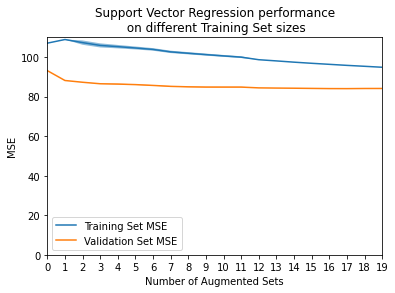

In [71]:
start_time = time.time()
svr = SVR(kernel = "rbf", cache_size=7000)
# No hyperparameter tuning since it would take far too long
best_duplicates_to_keep, best_size = learning_curve('Support Vector Regression', svr, XX, YY, True)
print("Time taken: ", time.time() - start_time)

In [17]:
best_duplicates_to_keep = 17

Grid Search Cross Validation for Inititalization with Hyperparameter Tuning

In [18]:
start_time = time.time()
modified_XX, modified_YY = reduce_dataset_size(XX, YY, get_rand_studyseqs(best_duplicates_to_keep))
modified_XX_train, modified_YY_train, modified_XX_test, modified_YY_test = split_by_cond(modified_XX, modified_YY, 'Cond_SE')
modified_XX_train, modified_YY_train = modified_XX_train.iloc[:,2:], modified_YY_train.iloc[:,2:] # drop cond and studyseq columns
modified_YY_train = modified_YY_train.values.flatten()

param_grid = {"C": np.logspace(-2, 2, num=5), "gamma": np.logspace(-6, 2, num=9), "epsilon": np.logspace(-3, 6, num=10)}
# 7 fold with shuffle=False holds one cond out on each inner fold of the predicted_vs_true function
kfolds = KFold(n_splits = 7, shuffle = False)
svr = GridSearchCV(estimator = SVR(kernel = "rbf", cache_size=7000), param_grid = param_grid, scoring = "neg_mean_squared_error", 
                   cv=kfolds, verbose=5)
svr.fit(modified_XX_train, modified_YY_train)

svr_init_params = svr.best_params_
print("Time taken: ", time.time() - start_time)

Fitting 7 folds for each of 450 candidates, totalling 3150 fits
[CV 1/7] END .............C=0.01, epsilon=0.001, gamma=1e-06; total time=   2.5s
[CV 2/7] END .............C=0.01, epsilon=0.001, gamma=1e-06; total time=   2.6s
[CV 3/7] END .............C=0.01, epsilon=0.001, gamma=1e-06; total time=   2.7s
[CV 4/7] END .............C=0.01, epsilon=0.001, gamma=1e-06; total time=   2.7s
[CV 5/7] END .............C=0.01, epsilon=0.001, gamma=1e-06; total time=   2.7s
[CV 6/7] END .............C=0.01, epsilon=0.001, gamma=1e-06; total time=   2.6s
[CV 7/7] END .............C=0.01, epsilon=0.001, gamma=1e-06; total time=   2.8s
[CV 1/7] END .............C=0.01, epsilon=0.001, gamma=1e-05; total time=   2.7s
[CV 2/7] END .............C=0.01, epsilon=0.001, gamma=1e-05; total time=   2.5s
[CV 3/7] END .............C=0.01, epsilon=0.001, gamma=1e-05; total time=   2.4s
[CV 4/7] END .............C=0.01, epsilon=0.001, gamma=1e-05; total time=   2.6s
[CV 5/7] END .............C=0.01, epsilon=0.0

[CV 4/7] END ................C=0.01, epsilon=0.01, gamma=0.1; total time=   2.3s
[CV 5/7] END ................C=0.01, epsilon=0.01, gamma=0.1; total time=   2.3s
[CV 6/7] END ................C=0.01, epsilon=0.01, gamma=0.1; total time=   2.5s
[CV 7/7] END ................C=0.01, epsilon=0.01, gamma=0.1; total time=   2.4s
[CV 1/7] END ................C=0.01, epsilon=0.01, gamma=1.0; total time=   2.4s
[CV 2/7] END ................C=0.01, epsilon=0.01, gamma=1.0; total time=   2.4s
[CV 3/7] END ................C=0.01, epsilon=0.01, gamma=1.0; total time=   2.4s
[CV 4/7] END ................C=0.01, epsilon=0.01, gamma=1.0; total time=   2.4s
[CV 5/7] END ................C=0.01, epsilon=0.01, gamma=1.0; total time=   2.4s
[CV 6/7] END ................C=0.01, epsilon=0.01, gamma=1.0; total time=   2.4s
[CV 7/7] END ................C=0.01, epsilon=0.01, gamma=1.0; total time=   2.4s
[CV 1/7] END ...............C=0.01, epsilon=0.01, gamma=10.0; total time=   2.7s
[CV 2/7] END ...............

[CV 1/7] END ..............C=0.01, epsilon=1.0, gamma=0.0001; total time=   2.6s
[CV 2/7] END ..............C=0.01, epsilon=1.0, gamma=0.0001; total time=   2.7s
[CV 3/7] END ..............C=0.01, epsilon=1.0, gamma=0.0001; total time=   2.4s
[CV 4/7] END ..............C=0.01, epsilon=1.0, gamma=0.0001; total time=   2.1s
[CV 5/7] END ..............C=0.01, epsilon=1.0, gamma=0.0001; total time=   2.4s
[CV 6/7] END ..............C=0.01, epsilon=1.0, gamma=0.0001; total time=   2.4s
[CV 7/7] END ..............C=0.01, epsilon=1.0, gamma=0.0001; total time=   2.5s
[CV 1/7] END ...............C=0.01, epsilon=1.0, gamma=0.001; total time=   2.2s
[CV 2/7] END ...............C=0.01, epsilon=1.0, gamma=0.001; total time=   2.5s
[CV 3/7] END ...............C=0.01, epsilon=1.0, gamma=0.001; total time=   2.3s
[CV 4/7] END ...............C=0.01, epsilon=1.0, gamma=0.001; total time=   2.2s
[CV 5/7] END ...............C=0.01, epsilon=1.0, gamma=0.001; total time=   2.5s
[CV 6/7] END ...............

[CV 5/7] END ...............C=0.01, epsilon=10.0, gamma=10.0; total time=   1.0s
[CV 6/7] END ...............C=0.01, epsilon=10.0, gamma=10.0; total time=   1.0s
[CV 7/7] END ...............C=0.01, epsilon=10.0, gamma=10.0; total time=   0.9s
[CV 1/7] END ..............C=0.01, epsilon=10.0, gamma=100.0; total time=   1.0s
[CV 2/7] END ..............C=0.01, epsilon=10.0, gamma=100.0; total time=   1.1s
[CV 3/7] END ..............C=0.01, epsilon=10.0, gamma=100.0; total time=   0.8s
[CV 4/7] END ..............C=0.01, epsilon=10.0, gamma=100.0; total time=   0.8s
[CV 5/7] END ..............C=0.01, epsilon=10.0, gamma=100.0; total time=   1.2s
[CV 6/7] END ..............C=0.01, epsilon=10.0, gamma=100.0; total time=   1.0s
[CV 7/7] END ..............C=0.01, epsilon=10.0, gamma=100.0; total time=   1.0s
[CV 1/7] END .............C=0.01, epsilon=100.0, gamma=1e-06; total time=   0.0s
[CV 2/7] END .............C=0.01, epsilon=100.0, gamma=1e-06; total time=   0.0s
[CV 3/7] END .............C=

[CV 2/7] END ..............C=0.01, epsilon=1000.0, gamma=1.0; total time=   0.0s
[CV 3/7] END ..............C=0.01, epsilon=1000.0, gamma=1.0; total time=   0.0s
[CV 4/7] END ..............C=0.01, epsilon=1000.0, gamma=1.0; total time=   0.0s
[CV 5/7] END ..............C=0.01, epsilon=1000.0, gamma=1.0; total time=   0.0s
[CV 6/7] END ..............C=0.01, epsilon=1000.0, gamma=1.0; total time=   0.0s
[CV 7/7] END ..............C=0.01, epsilon=1000.0, gamma=1.0; total time=   0.0s
[CV 1/7] END .............C=0.01, epsilon=1000.0, gamma=10.0; total time=   0.0s
[CV 2/7] END .............C=0.01, epsilon=1000.0, gamma=10.0; total time=   0.0s
[CV 3/7] END .............C=0.01, epsilon=1000.0, gamma=10.0; total time=   0.0s
[CV 4/7] END .............C=0.01, epsilon=1000.0, gamma=10.0; total time=   0.0s
[CV 5/7] END .............C=0.01, epsilon=1000.0, gamma=10.0; total time=   0.0s
[CV 6/7] END .............C=0.01, epsilon=1000.0, gamma=10.0; total time=   0.0s
[CV 7/7] END .............C=

[CV 3/7] END ..........C=0.01, epsilon=100000.0, gamma=0.001; total time=   0.0s
[CV 4/7] END ..........C=0.01, epsilon=100000.0, gamma=0.001; total time=   0.0s
[CV 5/7] END ..........C=0.01, epsilon=100000.0, gamma=0.001; total time=   0.0s
[CV 6/7] END ..........C=0.01, epsilon=100000.0, gamma=0.001; total time=   0.0s
[CV 7/7] END ..........C=0.01, epsilon=100000.0, gamma=0.001; total time=   0.0s
[CV 1/7] END ...........C=0.01, epsilon=100000.0, gamma=0.01; total time=   0.0s
[CV 2/7] END ...........C=0.01, epsilon=100000.0, gamma=0.01; total time=   0.0s
[CV 3/7] END ...........C=0.01, epsilon=100000.0, gamma=0.01; total time=   0.0s
[CV 4/7] END ...........C=0.01, epsilon=100000.0, gamma=0.01; total time=   0.0s
[CV 5/7] END ...........C=0.01, epsilon=100000.0, gamma=0.01; total time=   0.0s
[CV 6/7] END ...........C=0.01, epsilon=100000.0, gamma=0.01; total time=   0.0s
[CV 7/7] END ...........C=0.01, epsilon=100000.0, gamma=0.01; total time=   0.0s
[CV 1/7] END ............C=0

[CV 1/7] END ..............C=0.1, epsilon=0.001, gamma=1e-06; total time=   2.8s
[CV 2/7] END ..............C=0.1, epsilon=0.001, gamma=1e-06; total time=   2.5s
[CV 3/7] END ..............C=0.1, epsilon=0.001, gamma=1e-06; total time=   2.4s
[CV 4/7] END ..............C=0.1, epsilon=0.001, gamma=1e-06; total time=   2.4s
[CV 5/7] END ..............C=0.1, epsilon=0.001, gamma=1e-06; total time=   2.6s
[CV 6/7] END ..............C=0.1, epsilon=0.001, gamma=1e-06; total time=   2.6s
[CV 7/7] END ..............C=0.1, epsilon=0.001, gamma=1e-06; total time=   2.8s
[CV 1/7] END ..............C=0.1, epsilon=0.001, gamma=1e-05; total time=   3.2s
[CV 2/7] END ..............C=0.1, epsilon=0.001, gamma=1e-05; total time=   2.8s
[CV 3/7] END ..............C=0.1, epsilon=0.001, gamma=1e-05; total time=   2.5s
[CV 4/7] END ..............C=0.1, epsilon=0.001, gamma=1e-05; total time=   2.8s
[CV 5/7] END ..............C=0.1, epsilon=0.001, gamma=1e-05; total time=   2.8s
[CV 6/7] END ..............C

[CV 5/7] END .................C=0.1, epsilon=0.01, gamma=0.1; total time=   2.5s
[CV 6/7] END .................C=0.1, epsilon=0.01, gamma=0.1; total time=   2.4s
[CV 7/7] END .................C=0.1, epsilon=0.01, gamma=0.1; total time=   3.0s
[CV 1/7] END .................C=0.1, epsilon=0.01, gamma=1.0; total time=   2.5s
[CV 2/7] END .................C=0.1, epsilon=0.01, gamma=1.0; total time=   2.8s
[CV 3/7] END .................C=0.1, epsilon=0.01, gamma=1.0; total time=   2.9s
[CV 4/7] END .................C=0.1, epsilon=0.01, gamma=1.0; total time=   2.5s
[CV 5/7] END .................C=0.1, epsilon=0.01, gamma=1.0; total time=   2.6s
[CV 6/7] END .................C=0.1, epsilon=0.01, gamma=1.0; total time=   2.4s
[CV 7/7] END .................C=0.1, epsilon=0.01, gamma=1.0; total time=   2.5s
[CV 1/7] END ................C=0.1, epsilon=0.01, gamma=10.0; total time=   2.8s
[CV 2/7] END ................C=0.1, epsilon=0.01, gamma=10.0; total time=   3.0s
[CV 3/7] END ...............

[CV 2/7] END ...............C=0.1, epsilon=1.0, gamma=0.0001; total time=   2.8s
[CV 3/7] END ...............C=0.1, epsilon=1.0, gamma=0.0001; total time=   2.4s
[CV 4/7] END ...............C=0.1, epsilon=1.0, gamma=0.0001; total time=   2.4s
[CV 5/7] END ...............C=0.1, epsilon=1.0, gamma=0.0001; total time=   2.4s
[CV 6/7] END ...............C=0.1, epsilon=1.0, gamma=0.0001; total time=   2.4s
[CV 7/7] END ...............C=0.1, epsilon=1.0, gamma=0.0001; total time=   2.6s
[CV 1/7] END ................C=0.1, epsilon=1.0, gamma=0.001; total time=   2.3s
[CV 2/7] END ................C=0.1, epsilon=1.0, gamma=0.001; total time=   2.4s
[CV 3/7] END ................C=0.1, epsilon=1.0, gamma=0.001; total time=   2.7s
[CV 4/7] END ................C=0.1, epsilon=1.0, gamma=0.001; total time=   2.7s
[CV 5/7] END ................C=0.1, epsilon=1.0, gamma=0.001; total time=   2.5s
[CV 6/7] END ................C=0.1, epsilon=1.0, gamma=0.001; total time=   2.3s
[CV 7/7] END ...............

[CV 6/7] END ................C=0.1, epsilon=10.0, gamma=10.0; total time=   1.1s
[CV 7/7] END ................C=0.1, epsilon=10.0, gamma=10.0; total time=   1.0s
[CV 1/7] END ...............C=0.1, epsilon=10.0, gamma=100.0; total time=   1.0s
[CV 2/7] END ...............C=0.1, epsilon=10.0, gamma=100.0; total time=   1.1s
[CV 3/7] END ...............C=0.1, epsilon=10.0, gamma=100.0; total time=   0.8s
[CV 4/7] END ...............C=0.1, epsilon=10.0, gamma=100.0; total time=   0.8s
[CV 5/7] END ...............C=0.1, epsilon=10.0, gamma=100.0; total time=   1.4s
[CV 6/7] END ...............C=0.1, epsilon=10.0, gamma=100.0; total time=   1.8s
[CV 7/7] END ...............C=0.1, epsilon=10.0, gamma=100.0; total time=   1.6s
[CV 1/7] END ..............C=0.1, epsilon=100.0, gamma=1e-06; total time=   0.0s
[CV 2/7] END ..............C=0.1, epsilon=100.0, gamma=1e-06; total time=   0.0s
[CV 3/7] END ..............C=0.1, epsilon=100.0, gamma=1e-06; total time=   0.0s
[CV 4/7] END ..............C

[CV 1/7] END ...............C=0.1, epsilon=1000.0, gamma=0.1; total time=   0.0s
[CV 2/7] END ...............C=0.1, epsilon=1000.0, gamma=0.1; total time=   0.0s
[CV 3/7] END ...............C=0.1, epsilon=1000.0, gamma=0.1; total time=   0.0s
[CV 4/7] END ...............C=0.1, epsilon=1000.0, gamma=0.1; total time=   0.0s
[CV 5/7] END ...............C=0.1, epsilon=1000.0, gamma=0.1; total time=   0.0s
[CV 6/7] END ...............C=0.1, epsilon=1000.0, gamma=0.1; total time=   0.0s
[CV 7/7] END ...............C=0.1, epsilon=1000.0, gamma=0.1; total time=   0.0s
[CV 1/7] END ...............C=0.1, epsilon=1000.0, gamma=1.0; total time=   0.0s
[CV 2/7] END ...............C=0.1, epsilon=1000.0, gamma=1.0; total time=   0.0s
[CV 3/7] END ...............C=0.1, epsilon=1000.0, gamma=1.0; total time=   0.0s
[CV 4/7] END ...............C=0.1, epsilon=1000.0, gamma=1.0; total time=   0.0s
[CV 5/7] END ...............C=0.1, epsilon=1000.0, gamma=1.0; total time=   0.0s
[CV 6/7] END ...............

[CV 7/7] END ...........C=0.1, epsilon=100000.0, gamma=1e-05; total time=   0.0s
[CV 1/7] END ..........C=0.1, epsilon=100000.0, gamma=0.0001; total time=   0.0s
[CV 2/7] END ..........C=0.1, epsilon=100000.0, gamma=0.0001; total time=   0.0s
[CV 3/7] END ..........C=0.1, epsilon=100000.0, gamma=0.0001; total time=   0.0s
[CV 4/7] END ..........C=0.1, epsilon=100000.0, gamma=0.0001; total time=   0.0s
[CV 5/7] END ..........C=0.1, epsilon=100000.0, gamma=0.0001; total time=   0.0s
[CV 6/7] END ..........C=0.1, epsilon=100000.0, gamma=0.0001; total time=   0.0s
[CV 7/7] END ..........C=0.1, epsilon=100000.0, gamma=0.0001; total time=   0.0s
[CV 1/7] END ...........C=0.1, epsilon=100000.0, gamma=0.001; total time=   0.0s
[CV 2/7] END ...........C=0.1, epsilon=100000.0, gamma=0.001; total time=   0.0s
[CV 3/7] END ...........C=0.1, epsilon=100000.0, gamma=0.001; total time=   0.0s
[CV 4/7] END ...........C=0.1, epsilon=100000.0, gamma=0.001; total time=   0.0s
[CV 5/7] END ...........C=0.

[CV 6/7] END ...........C=0.1, epsilon=1000000.0, gamma=10.0; total time=   0.0s
[CV 7/7] END ...........C=0.1, epsilon=1000000.0, gamma=10.0; total time=   0.0s
[CV 1/7] END ..........C=0.1, epsilon=1000000.0, gamma=100.0; total time=   0.0s
[CV 2/7] END ..........C=0.1, epsilon=1000000.0, gamma=100.0; total time=   0.0s
[CV 3/7] END ..........C=0.1, epsilon=1000000.0, gamma=100.0; total time=   0.0s
[CV 4/7] END ..........C=0.1, epsilon=1000000.0, gamma=100.0; total time=   0.0s
[CV 5/7] END ..........C=0.1, epsilon=1000000.0, gamma=100.0; total time=   0.0s
[CV 6/7] END ..........C=0.1, epsilon=1000000.0, gamma=100.0; total time=   0.0s
[CV 7/7] END ..........C=0.1, epsilon=1000000.0, gamma=100.0; total time=   0.0s
[CV 1/7] END ..............C=1.0, epsilon=0.001, gamma=1e-06; total time=   2.8s
[CV 2/7] END ..............C=1.0, epsilon=0.001, gamma=1e-06; total time=   2.4s
[CV 3/7] END ..............C=1.0, epsilon=0.001, gamma=1e-06; total time=   2.4s
[CV 4/7] END ..............C

[CV 3/7] END ................C=1.0, epsilon=0.01, gamma=0.01; total time=   2.7s
[CV 4/7] END ................C=1.0, epsilon=0.01, gamma=0.01; total time=   2.5s
[CV 5/7] END ................C=1.0, epsilon=0.01, gamma=0.01; total time=   2.5s
[CV 6/7] END ................C=1.0, epsilon=0.01, gamma=0.01; total time=   2.4s
[CV 7/7] END ................C=1.0, epsilon=0.01, gamma=0.01; total time=   2.5s
[CV 1/7] END .................C=1.0, epsilon=0.01, gamma=0.1; total time=   3.1s
[CV 2/7] END .................C=1.0, epsilon=0.01, gamma=0.1; total time=   2.9s
[CV 3/7] END .................C=1.0, epsilon=0.01, gamma=0.1; total time=   2.7s
[CV 4/7] END .................C=1.0, epsilon=0.01, gamma=0.1; total time=   2.8s
[CV 5/7] END .................C=1.0, epsilon=0.01, gamma=0.1; total time=   2.8s
[CV 6/7] END .................C=1.0, epsilon=0.01, gamma=0.1; total time=   3.1s
[CV 7/7] END .................C=1.0, epsilon=0.01, gamma=0.1; total time=   2.7s
[CV 1/7] END ...............

[CV 7/7] END ................C=1.0, epsilon=1.0, gamma=1e-06; total time=   2.4s
[CV 1/7] END ................C=1.0, epsilon=1.0, gamma=1e-05; total time=   2.3s
[CV 2/7] END ................C=1.0, epsilon=1.0, gamma=1e-05; total time=   2.7s
[CV 3/7] END ................C=1.0, epsilon=1.0, gamma=1e-05; total time=   2.2s
[CV 4/7] END ................C=1.0, epsilon=1.0, gamma=1e-05; total time=   2.3s
[CV 5/7] END ................C=1.0, epsilon=1.0, gamma=1e-05; total time=   2.6s
[CV 6/7] END ................C=1.0, epsilon=1.0, gamma=1e-05; total time=   2.5s
[CV 7/7] END ................C=1.0, epsilon=1.0, gamma=1e-05; total time=   2.2s
[CV 1/7] END ...............C=1.0, epsilon=1.0, gamma=0.0001; total time=   2.2s
[CV 2/7] END ...............C=1.0, epsilon=1.0, gamma=0.0001; total time=   2.2s
[CV 3/7] END ...............C=1.0, epsilon=1.0, gamma=0.0001; total time=   2.3s
[CV 4/7] END ...............C=1.0, epsilon=1.0, gamma=0.0001; total time=   2.2s
[CV 5/7] END ...............

[CV 4/7] END .................C=1.0, epsilon=10.0, gamma=1.0; total time=   0.6s
[CV 5/7] END .................C=1.0, epsilon=10.0, gamma=1.0; total time=   0.7s
[CV 6/7] END .................C=1.0, epsilon=10.0, gamma=1.0; total time=   0.5s
[CV 7/7] END .................C=1.0, epsilon=10.0, gamma=1.0; total time=   0.5s
[CV 1/7] END ................C=1.0, epsilon=10.0, gamma=10.0; total time=   1.5s
[CV 2/7] END ................C=1.0, epsilon=10.0, gamma=10.0; total time=   1.5s
[CV 3/7] END ................C=1.0, epsilon=10.0, gamma=10.0; total time=   1.1s
[CV 4/7] END ................C=1.0, epsilon=10.0, gamma=10.0; total time=   0.9s
[CV 5/7] END ................C=1.0, epsilon=10.0, gamma=10.0; total time=   1.7s
[CV 6/7] END ................C=1.0, epsilon=10.0, gamma=10.0; total time=   2.0s
[CV 7/7] END ................C=1.0, epsilon=10.0, gamma=10.0; total time=   1.5s
[CV 1/7] END ...............C=1.0, epsilon=10.0, gamma=100.0; total time=   1.3s
[CV 2/7] END ...............

[CV 3/7] END ..............C=1.0, epsilon=1000.0, gamma=0.01; total time=   0.0s
[CV 4/7] END ..............C=1.0, epsilon=1000.0, gamma=0.01; total time=   0.0s
[CV 5/7] END ..............C=1.0, epsilon=1000.0, gamma=0.01; total time=   0.0s
[CV 6/7] END ..............C=1.0, epsilon=1000.0, gamma=0.01; total time=   0.0s
[CV 7/7] END ..............C=1.0, epsilon=1000.0, gamma=0.01; total time=   0.0s
[CV 1/7] END ...............C=1.0, epsilon=1000.0, gamma=0.1; total time=   0.0s
[CV 2/7] END ...............C=1.0, epsilon=1000.0, gamma=0.1; total time=   0.0s
[CV 3/7] END ...............C=1.0, epsilon=1000.0, gamma=0.1; total time=   0.0s
[CV 4/7] END ...............C=1.0, epsilon=1000.0, gamma=0.1; total time=   0.0s
[CV 5/7] END ...............C=1.0, epsilon=1000.0, gamma=0.1; total time=   0.0s
[CV 6/7] END ...............C=1.0, epsilon=1000.0, gamma=0.1; total time=   0.0s
[CV 7/7] END ...............C=1.0, epsilon=1000.0, gamma=0.1; total time=   0.0s
[CV 1/7] END ...............

[CV 4/7] END ..........C=1.0, epsilon=100000.0, gamma=0.0001; total time=   0.0s
[CV 5/7] END ..........C=1.0, epsilon=100000.0, gamma=0.0001; total time=   0.0s
[CV 6/7] END ..........C=1.0, epsilon=100000.0, gamma=0.0001; total time=   0.0s
[CV 7/7] END ..........C=1.0, epsilon=100000.0, gamma=0.0001; total time=   0.0s
[CV 1/7] END ...........C=1.0, epsilon=100000.0, gamma=0.001; total time=   0.0s
[CV 2/7] END ...........C=1.0, epsilon=100000.0, gamma=0.001; total time=   0.0s
[CV 3/7] END ...........C=1.0, epsilon=100000.0, gamma=0.001; total time=   0.0s
[CV 4/7] END ...........C=1.0, epsilon=100000.0, gamma=0.001; total time=   0.0s
[CV 5/7] END ...........C=1.0, epsilon=100000.0, gamma=0.001; total time=   0.0s
[CV 6/7] END ...........C=1.0, epsilon=100000.0, gamma=0.001; total time=   0.0s
[CV 7/7] END ...........C=1.0, epsilon=100000.0, gamma=0.001; total time=   0.0s
[CV 1/7] END ............C=1.0, epsilon=100000.0, gamma=0.01; total time=   0.0s
[CV 2/7] END ............C=1

[CV 1/7] END .............C=10.0, epsilon=0.001, gamma=1e-06; total time=   2.5s
[CV 2/7] END .............C=10.0, epsilon=0.001, gamma=1e-06; total time=   2.4s
[CV 3/7] END .............C=10.0, epsilon=0.001, gamma=1e-06; total time=   2.5s
[CV 4/7] END .............C=10.0, epsilon=0.001, gamma=1e-06; total time=   2.5s
[CV 5/7] END .............C=10.0, epsilon=0.001, gamma=1e-06; total time=   2.7s
[CV 6/7] END .............C=10.0, epsilon=0.001, gamma=1e-06; total time=   2.6s
[CV 7/7] END .............C=10.0, epsilon=0.001, gamma=1e-06; total time=   3.5s
[CV 1/7] END .............C=10.0, epsilon=0.001, gamma=1e-05; total time=   2.8s
[CV 2/7] END .............C=10.0, epsilon=0.001, gamma=1e-05; total time=   3.0s
[CV 3/7] END .............C=10.0, epsilon=0.001, gamma=1e-05; total time=   2.8s
[CV 4/7] END .............C=10.0, epsilon=0.001, gamma=1e-05; total time=   2.8s
[CV 5/7] END .............C=10.0, epsilon=0.001, gamma=1e-05; total time=   2.7s
[CV 6/7] END .............C=

[CV 5/7] END ................C=10.0, epsilon=0.01, gamma=0.1; total time=   4.3s
[CV 6/7] END ................C=10.0, epsilon=0.01, gamma=0.1; total time=   4.1s
[CV 7/7] END ................C=10.0, epsilon=0.01, gamma=0.1; total time=   4.3s
[CV 1/7] END ................C=10.0, epsilon=0.01, gamma=1.0; total time=  12.0s
[CV 2/7] END ................C=10.0, epsilon=0.01, gamma=1.0; total time=  11.3s
[CV 3/7] END ................C=10.0, epsilon=0.01, gamma=1.0; total time=  11.5s
[CV 4/7] END ................C=10.0, epsilon=0.01, gamma=1.0; total time=  10.7s
[CV 5/7] END ................C=10.0, epsilon=0.01, gamma=1.0; total time=  11.6s
[CV 6/7] END ................C=10.0, epsilon=0.01, gamma=1.0; total time=  10.9s
[CV 7/7] END ................C=10.0, epsilon=0.01, gamma=1.0; total time=  12.2s
[CV 1/7] END ...............C=10.0, epsilon=0.01, gamma=10.0; total time=  19.1s
[CV 2/7] END ...............C=10.0, epsilon=0.01, gamma=10.0; total time=  19.6s
[CV 3/7] END ...............

[CV 2/7] END ..............C=10.0, epsilon=1.0, gamma=0.0001; total time=   2.2s
[CV 3/7] END ..............C=10.0, epsilon=1.0, gamma=0.0001; total time=   2.2s
[CV 4/7] END ..............C=10.0, epsilon=1.0, gamma=0.0001; total time=   2.1s
[CV 5/7] END ..............C=10.0, epsilon=1.0, gamma=0.0001; total time=   2.2s
[CV 6/7] END ..............C=10.0, epsilon=1.0, gamma=0.0001; total time=   2.2s
[CV 7/7] END ..............C=10.0, epsilon=1.0, gamma=0.0001; total time=   2.5s
[CV 1/7] END ...............C=10.0, epsilon=1.0, gamma=0.001; total time=   2.5s
[CV 2/7] END ...............C=10.0, epsilon=1.0, gamma=0.001; total time=   2.4s
[CV 3/7] END ...............C=10.0, epsilon=1.0, gamma=0.001; total time=   2.4s
[CV 4/7] END ...............C=10.0, epsilon=1.0, gamma=0.001; total time=   2.4s
[CV 5/7] END ...............C=10.0, epsilon=1.0, gamma=0.001; total time=   2.4s
[CV 6/7] END ...............C=10.0, epsilon=1.0, gamma=0.001; total time=   2.4s
[CV 7/7] END ...............

[CV 6/7] END ...............C=10.0, epsilon=10.0, gamma=10.0; total time=   2.9s
[CV 7/7] END ...............C=10.0, epsilon=10.0, gamma=10.0; total time=   2.6s
[CV 1/7] END ..............C=10.0, epsilon=10.0, gamma=100.0; total time=   4.8s
[CV 2/7] END ..............C=10.0, epsilon=10.0, gamma=100.0; total time=   5.1s
[CV 3/7] END ..............C=10.0, epsilon=10.0, gamma=100.0; total time=   3.7s
[CV 4/7] END ..............C=10.0, epsilon=10.0, gamma=100.0; total time=   3.7s
[CV 5/7] END ..............C=10.0, epsilon=10.0, gamma=100.0; total time=   5.2s
[CV 6/7] END ..............C=10.0, epsilon=10.0, gamma=100.0; total time=   5.0s
[CV 7/7] END ..............C=10.0, epsilon=10.0, gamma=100.0; total time=   4.7s
[CV 1/7] END .............C=10.0, epsilon=100.0, gamma=1e-06; total time=   0.0s
[CV 2/7] END .............C=10.0, epsilon=100.0, gamma=1e-06; total time=   0.0s
[CV 3/7] END .............C=10.0, epsilon=100.0, gamma=1e-06; total time=   0.0s
[CV 4/7] END .............C=

[CV 6/7] END .............C=10.0, epsilon=1000.0, gamma=0.01; total time=   0.0s
[CV 7/7] END .............C=10.0, epsilon=1000.0, gamma=0.01; total time=   0.0s
[CV 1/7] END ..............C=10.0, epsilon=1000.0, gamma=0.1; total time=   0.0s
[CV 2/7] END ..............C=10.0, epsilon=1000.0, gamma=0.1; total time=   0.0s
[CV 3/7] END ..............C=10.0, epsilon=1000.0, gamma=0.1; total time=   0.0s
[CV 4/7] END ..............C=10.0, epsilon=1000.0, gamma=0.1; total time=   0.0s
[CV 5/7] END ..............C=10.0, epsilon=1000.0, gamma=0.1; total time=   0.0s
[CV 6/7] END ..............C=10.0, epsilon=1000.0, gamma=0.1; total time=   0.0s
[CV 7/7] END ..............C=10.0, epsilon=1000.0, gamma=0.1; total time=   0.0s
[CV 1/7] END ..............C=10.0, epsilon=1000.0, gamma=1.0; total time=   0.0s
[CV 2/7] END ..............C=10.0, epsilon=1000.0, gamma=1.0; total time=   0.0s
[CV 3/7] END ..............C=10.0, epsilon=1000.0, gamma=1.0; total time=   0.0s
[CV 4/7] END ..............C

[CV 7/7] END .........C=10.0, epsilon=100000.0, gamma=0.0001; total time=   0.0s
[CV 1/7] END ..........C=10.0, epsilon=100000.0, gamma=0.001; total time=   0.0s
[CV 2/7] END ..........C=10.0, epsilon=100000.0, gamma=0.001; total time=   0.0s
[CV 3/7] END ..........C=10.0, epsilon=100000.0, gamma=0.001; total time=   0.0s
[CV 4/7] END ..........C=10.0, epsilon=100000.0, gamma=0.001; total time=   0.0s
[CV 5/7] END ..........C=10.0, epsilon=100000.0, gamma=0.001; total time=   0.0s
[CV 6/7] END ..........C=10.0, epsilon=100000.0, gamma=0.001; total time=   0.0s
[CV 7/7] END ..........C=10.0, epsilon=100000.0, gamma=0.001; total time=   0.0s
[CV 1/7] END ...........C=10.0, epsilon=100000.0, gamma=0.01; total time=   0.0s
[CV 2/7] END ...........C=10.0, epsilon=100000.0, gamma=0.01; total time=   0.0s
[CV 3/7] END ...........C=10.0, epsilon=100000.0, gamma=0.01; total time=   0.0s
[CV 4/7] END ...........C=10.0, epsilon=100000.0, gamma=0.01; total time=   0.0s
[CV 5/7] END ...........C=10

[CV 1/7] END ............C=100.0, epsilon=0.001, gamma=1e-06; total time=   2.5s
[CV 2/7] END ............C=100.0, epsilon=0.001, gamma=1e-06; total time=   2.5s
[CV 3/7] END ............C=100.0, epsilon=0.001, gamma=1e-06; total time=   2.6s
[CV 4/7] END ............C=100.0, epsilon=0.001, gamma=1e-06; total time=   2.6s
[CV 5/7] END ............C=100.0, epsilon=0.001, gamma=1e-06; total time=   2.5s
[CV 6/7] END ............C=100.0, epsilon=0.001, gamma=1e-06; total time=   2.5s
[CV 7/7] END ............C=100.0, epsilon=0.001, gamma=1e-06; total time=   2.5s
[CV 1/7] END ............C=100.0, epsilon=0.001, gamma=1e-05; total time=   2.4s
[CV 2/7] END ............C=100.0, epsilon=0.001, gamma=1e-05; total time=   2.5s
[CV 3/7] END ............C=100.0, epsilon=0.001, gamma=1e-05; total time=   2.5s
[CV 4/7] END ............C=100.0, epsilon=0.001, gamma=1e-05; total time=   2.4s
[CV 5/7] END ............C=100.0, epsilon=0.001, gamma=1e-05; total time=   2.4s
[CV 6/7] END ............C=1

[CV 5/7] END ...............C=100.0, epsilon=0.01, gamma=0.1; total time=  27.7s
[CV 6/7] END ...............C=100.0, epsilon=0.01, gamma=0.1; total time=  19.1s
[CV 7/7] END ...............C=100.0, epsilon=0.01, gamma=0.1; total time=  18.3s
[CV 1/7] END ...............C=100.0, epsilon=0.01, gamma=1.0; total time= 1.7min
[CV 2/7] END ...............C=100.0, epsilon=0.01, gamma=1.0; total time= 1.5min
[CV 3/7] END ...............C=100.0, epsilon=0.01, gamma=1.0; total time= 1.5min
[CV 4/7] END ...............C=100.0, epsilon=0.01, gamma=1.0; total time= 1.5min
[CV 5/7] END ...............C=100.0, epsilon=0.01, gamma=1.0; total time= 1.6min
[CV 6/7] END ...............C=100.0, epsilon=0.01, gamma=1.0; total time= 1.5min
[CV 7/7] END ...............C=100.0, epsilon=0.01, gamma=1.0; total time= 1.4min
[CV 1/7] END ..............C=100.0, epsilon=0.01, gamma=10.0; total time=  28.0s
[CV 2/7] END ..............C=100.0, epsilon=0.01, gamma=10.0; total time=  28.6s
[CV 3/7] END ..............C

[CV 2/7] END .............C=100.0, epsilon=1.0, gamma=0.0001; total time=   2.8s
[CV 3/7] END .............C=100.0, epsilon=1.0, gamma=0.0001; total time=   2.7s
[CV 4/7] END .............C=100.0, epsilon=1.0, gamma=0.0001; total time=   2.8s
[CV 5/7] END .............C=100.0, epsilon=1.0, gamma=0.0001; total time=   2.8s
[CV 6/7] END .............C=100.0, epsilon=1.0, gamma=0.0001; total time=   2.9s
[CV 7/7] END .............C=100.0, epsilon=1.0, gamma=0.0001; total time=   2.8s
[CV 1/7] END ..............C=100.0, epsilon=1.0, gamma=0.001; total time=   3.0s
[CV 2/7] END ..............C=100.0, epsilon=1.0, gamma=0.001; total time=   3.2s
[CV 3/7] END ..............C=100.0, epsilon=1.0, gamma=0.001; total time=   4.1s
[CV 4/7] END ..............C=100.0, epsilon=1.0, gamma=0.001; total time=   4.4s
[CV 5/7] END ..............C=100.0, epsilon=1.0, gamma=0.001; total time=   5.4s
[CV 6/7] END ..............C=100.0, epsilon=1.0, gamma=0.001; total time=   5.1s
[CV 7/7] END ..............C

[CV 6/7] END ..............C=100.0, epsilon=10.0, gamma=10.0; total time=   2.9s
[CV 7/7] END ..............C=100.0, epsilon=10.0, gamma=10.0; total time=   3.1s
[CV 1/7] END .............C=100.0, epsilon=10.0, gamma=100.0; total time=   5.4s
[CV 2/7] END .............C=100.0, epsilon=10.0, gamma=100.0; total time=   5.5s
[CV 3/7] END .............C=100.0, epsilon=10.0, gamma=100.0; total time=   3.8s
[CV 4/7] END .............C=100.0, epsilon=10.0, gamma=100.0; total time=   3.5s
[CV 5/7] END .............C=100.0, epsilon=10.0, gamma=100.0; total time=   4.9s
[CV 6/7] END .............C=100.0, epsilon=10.0, gamma=100.0; total time=   5.5s
[CV 7/7] END .............C=100.0, epsilon=10.0, gamma=100.0; total time=   5.5s
[CV 1/7] END ............C=100.0, epsilon=100.0, gamma=1e-06; total time=   0.0s
[CV 2/7] END ............C=100.0, epsilon=100.0, gamma=1e-06; total time=   0.0s
[CV 3/7] END ............C=100.0, epsilon=100.0, gamma=1e-06; total time=   0.0s
[CV 4/7] END ............C=1

[CV 5/7] END .............C=100.0, epsilon=1000.0, gamma=0.1; total time=   0.0s
[CV 6/7] END .............C=100.0, epsilon=1000.0, gamma=0.1; total time=   0.0s
[CV 7/7] END .............C=100.0, epsilon=1000.0, gamma=0.1; total time=   0.0s
[CV 1/7] END .............C=100.0, epsilon=1000.0, gamma=1.0; total time=   0.0s
[CV 2/7] END .............C=100.0, epsilon=1000.0, gamma=1.0; total time=   0.0s
[CV 3/7] END .............C=100.0, epsilon=1000.0, gamma=1.0; total time=   0.0s
[CV 4/7] END .............C=100.0, epsilon=1000.0, gamma=1.0; total time=   0.0s
[CV 5/7] END .............C=100.0, epsilon=1000.0, gamma=1.0; total time=   0.0s
[CV 6/7] END .............C=100.0, epsilon=1000.0, gamma=1.0; total time=   0.0s
[CV 7/7] END .............C=100.0, epsilon=1000.0, gamma=1.0; total time=   0.0s
[CV 1/7] END ............C=100.0, epsilon=1000.0, gamma=10.0; total time=   0.0s
[CV 2/7] END ............C=100.0, epsilon=1000.0, gamma=10.0; total time=   0.0s
[CV 3/7] END ............C=1

[CV 7/7] END ........C=100.0, epsilon=100000.0, gamma=0.0001; total time=   0.0s
[CV 1/7] END .........C=100.0, epsilon=100000.0, gamma=0.001; total time=   0.0s
[CV 2/7] END .........C=100.0, epsilon=100000.0, gamma=0.001; total time=   0.0s
[CV 3/7] END .........C=100.0, epsilon=100000.0, gamma=0.001; total time=   0.0s
[CV 4/7] END .........C=100.0, epsilon=100000.0, gamma=0.001; total time=   0.0s
[CV 5/7] END .........C=100.0, epsilon=100000.0, gamma=0.001; total time=   0.0s
[CV 6/7] END .........C=100.0, epsilon=100000.0, gamma=0.001; total time=   0.0s
[CV 7/7] END .........C=100.0, epsilon=100000.0, gamma=0.001; total time=   0.0s
[CV 1/7] END ..........C=100.0, epsilon=100000.0, gamma=0.01; total time=   0.0s
[CV 2/7] END ..........C=100.0, epsilon=100000.0, gamma=0.01; total time=   0.0s
[CV 3/7] END ..........C=100.0, epsilon=100000.0, gamma=0.01; total time=   0.0s
[CV 4/7] END ..........C=100.0, epsilon=100000.0, gamma=0.01; total time=   0.0s
[CV 5/7] END ..........C=100

[CV 6/7] END ........C=100.0, epsilon=1000000.0, gamma=100.0; total time=   0.0s
[CV 7/7] END ........C=100.0, epsilon=1000000.0, gamma=100.0; total time=   0.0s
Time taken:  8679.092600107193


In [19]:
print(svr_init_params)

{'C': 10.0, 'epsilon': 0.1, 'gamma': 0.1}


Hyperparameter Tuning

Tuning epsilon

Outer Fold:  1 / 8  Complete.
Outer Fold:  2 / 8  Complete.
Outer Fold:  3 / 8  Complete.
Outer Fold:  4 / 8  Complete.
Outer Fold:  5 / 8  Complete.
Outer Fold:  6 / 8  Complete.
Outer Fold:  7 / 8  Complete.
Outer Fold:  8 / 8  Complete.
Time taken:  625.7872755527496


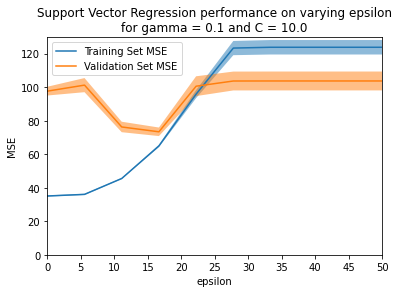

In [20]:
start_time = time.time()
svr = SVR(kernel = "rbf", gamma = svr_init_params['gamma'], C = svr_init_params['C'])
extra_string = '\nfor gamma = ' + str(svr_init_params['gamma']) + ' and C = ' + str(svr_init_params['C'])
param_grid = {"epsilon": np.linspace(0, 50, num=10)}
xticks = np.linspace(0, 50, num=11)
validation_curve('Support Vector Regression', svr, XX, YY, best_duplicates_to_keep, param_grid, False, True, extra_string, xticks)
print("Time taken: ", time.time() - start_time)

Tuning gamma

Outer Fold:  1 / 8  Complete.
Outer Fold:  2 / 8  Complete.
Outer Fold:  3 / 8  Complete.
Outer Fold:  4 / 8  Complete.
Outer Fold:  5 / 8  Complete.
Outer Fold:  6 / 8  Complete.
Outer Fold:  7 / 8  Complete.
Outer Fold:  8 / 8  Complete.
Time taken:  4185.6097502708435


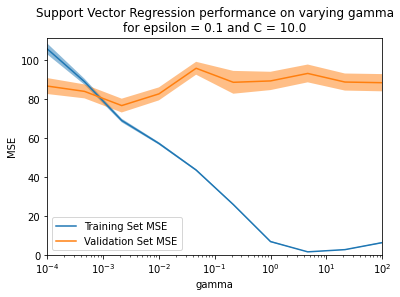

In [21]:
start_time = time.time()
svr = SVR(kernel = "rbf", epsilon = svr_init_params['epsilon'], C = svr_init_params['C'])
extra_string = '\nfor epsilon = ' + str(svr_init_params['epsilon']) + ' and C = ' + str(svr_init_params['C'])
param_grid = {"gamma": np.logspace(-4, 2, num=10)}
xticks = np.logspace(-4, 2, num=7)
validation_curve('Support Vector Regression', svr, XX, YY, best_duplicates_to_keep, param_grid, True, True, extra_string, xticks)
print("Time taken: ", time.time() - start_time)

Tuning C

Outer Fold:  1 / 8  Complete.
Outer Fold:  2 / 8  Complete.
Outer Fold:  3 / 8  Complete.
Outer Fold:  4 / 8  Complete.
Outer Fold:  5 / 8  Complete.
Outer Fold:  6 / 8  Complete.
Outer Fold:  7 / 8  Complete.
Outer Fold:  8 / 8  Complete.
Time taken:  4900.609872817993


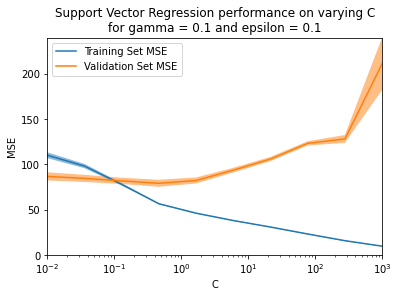

In [22]:
start_time = time.time()
svr = SVR(kernel = "rbf", gamma = svr_init_params['gamma'], epsilon = svr_init_params['epsilon'])
extra_string = '\nfor gamma = ' + str(svr_init_params['gamma']) + ' and epsilon = ' + str(svr_init_params['epsilon'])
param_grid = {"C": np.logspace(-2, 3, num=10)}
xticks = np.logspace(-2, 3, num=6)
validation_curve('Support Vector Regression', svr, XX, YY, best_duplicates_to_keep, param_grid, True, True, extra_string, xticks)
print("Time taken: ", time.time() - start_time)

Predictions VS True Values on Test Set

Fold  1 /8 Complete
Fold  2 /8 Complete
Fold  3 /8 Complete
Fold  4 /8 Complete
Fold  5 /8 Complete
Fold  6 /8 Complete
Fold  7 /8 Complete
Fold  8 /8 Complete
Pearson Correlation Coefficient = -0.22605919121905302
Mean Squared Error =  118.43420492584664
Train Mean Squared Error =  58.17456109600468
Time taken:  5712.831364870071


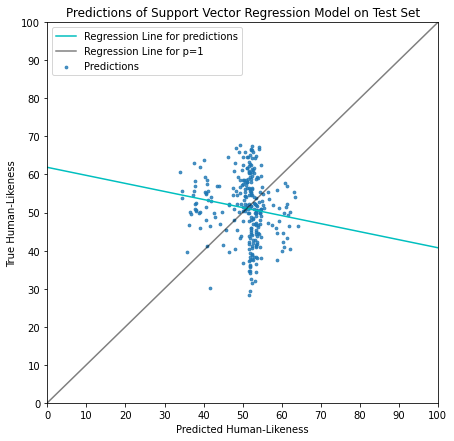

In [25]:
start_time = time.time()
# 7 fold with shuffle=False holds one cond out on each inner fold of the predicted_vs_true function
kfolds = KFold(n_splits = 7, shuffle = False)
param_grid = {"C": np.logspace(-2, 3, num=5), "gamma": np.logspace(-4, 2, num=5), "epsilon": np.linspace(0, 50, num=5)}
predicted_vs_true('Support Vector Regression', SVR(kernel = "rbf"), XX, YY, best_duplicates_to_keep, param_grid, True)
print("Time taken: ", time.time() - start_time)

# Linear Regression

Tune amount of synthesised data

Shuffle:  1 / 5  Outer Cond: 1 / 8
Shuffle:  1 / 5  Outer Cond: 2 / 8
Shuffle:  1 / 5  Outer Cond: 3 / 8
Shuffle:  1 / 5  Outer Cond: 4 / 8
Shuffle:  1 / 5  Outer Cond: 5 / 8
Shuffle:  1 / 5  Outer Cond: 6 / 8
Shuffle:  1 / 5  Outer Cond: 7 / 8
Shuffle:  1 / 5  Outer Cond: 8 / 8
Shuffle:  2 / 5  Outer Cond: 1 / 8
Shuffle:  2 / 5  Outer Cond: 2 / 8
Shuffle:  2 / 5  Outer Cond: 3 / 8
Shuffle:  2 / 5  Outer Cond: 4 / 8
Shuffle:  2 / 5  Outer Cond: 5 / 8
Shuffle:  2 / 5  Outer Cond: 6 / 8
Shuffle:  2 / 5  Outer Cond: 7 / 8
Shuffle:  2 / 5  Outer Cond: 8 / 8
Shuffle:  3 / 5  Outer Cond: 1 / 8
Shuffle:  3 / 5  Outer Cond: 2 / 8
Shuffle:  3 / 5  Outer Cond: 3 / 8
Shuffle:  3 / 5  Outer Cond: 4 / 8
Shuffle:  3 / 5  Outer Cond: 5 / 8
Shuffle:  3 / 5  Outer Cond: 6 / 8
Shuffle:  3 / 5  Outer Cond: 7 / 8
Shuffle:  3 / 5  Outer Cond: 8 / 8
Shuffle:  4 / 5  Outer Cond: 1 / 8
Shuffle:  4 / 5  Outer Cond: 2 / 8
Shuffle:  4 / 5  Outer Cond: 3 / 8
Shuffle:  4 / 5  Outer Cond: 4 / 8
Shuffle:  4 / 5  Out

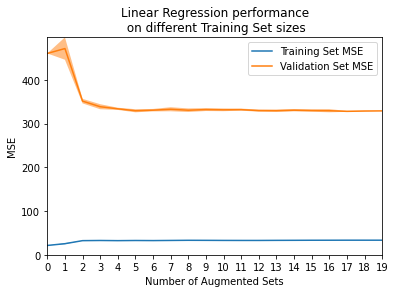

In [66]:
start_time = time.time()
best_duplicates_to_keep, best_size = learning_curve('Linear Regression', LinearRegression(), XX, YY, True)
print("Time taken: ", time.time() - start_time)

Shuffle:  1 / 5  Outer Cond: 1 / 8
Shuffle:  1 / 5  Outer Cond: 2 / 8
Shuffle:  1 / 5  Outer Cond: 3 / 8
Shuffle:  1 / 5  Outer Cond: 4 / 8
Shuffle:  1 / 5  Outer Cond: 5 / 8
Shuffle:  1 / 5  Outer Cond: 6 / 8
Shuffle:  1 / 5  Outer Cond: 7 / 8
Shuffle:  1 / 5  Outer Cond: 8 / 8
Shuffle:  2 / 5  Outer Cond: 1 / 8
Shuffle:  2 / 5  Outer Cond: 2 / 8
Shuffle:  2 / 5  Outer Cond: 3 / 8
Shuffle:  2 / 5  Outer Cond: 4 / 8
Shuffle:  2 / 5  Outer Cond: 5 / 8
Shuffle:  2 / 5  Outer Cond: 6 / 8
Shuffle:  2 / 5  Outer Cond: 7 / 8
Shuffle:  2 / 5  Outer Cond: 8 / 8
Shuffle:  3 / 5  Outer Cond: 1 / 8
Shuffle:  3 / 5  Outer Cond: 2 / 8
Shuffle:  3 / 5  Outer Cond: 3 / 8
Shuffle:  3 / 5  Outer Cond: 4 / 8
Shuffle:  3 / 5  Outer Cond: 5 / 8
Shuffle:  3 / 5  Outer Cond: 6 / 8
Shuffle:  3 / 5  Outer Cond: 7 / 8
Shuffle:  3 / 5  Outer Cond: 8 / 8
Shuffle:  4 / 5  Outer Cond: 1 / 8
Shuffle:  4 / 5  Outer Cond: 2 / 8
Shuffle:  4 / 5  Outer Cond: 3 / 8
Shuffle:  4 / 5  Outer Cond: 4 / 8
Shuffle:  4 / 5  Out

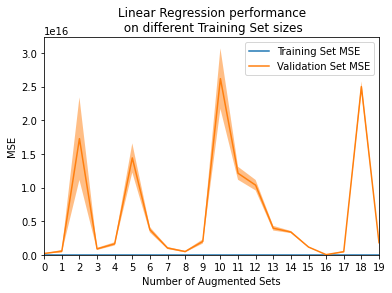

In [67]:
start_time = time.time()
best_duplicates_to_keep, best_size = learning_curve('Linear Regression', LinearRegression(), XX, YY, False)
print("Time taken: ", time.time() - start_time)

In [26]:
best_duplicates_to_keep=17

Predicted VS True Values on Test Set

Fold  1 /8 Complete
Fold  2 /8 Complete
Fold  3 /8 Complete
Fold  4 /8 Complete
Fold  5 /8 Complete
Fold  6 /8 Complete
Fold  7 /8 Complete
Fold  8 /8 Complete
Pearson Correlation Coefficient = -0.0026445861286313057
Mean Squared Error =  278.9412770307119
Train Mean Squared Error =  35.985258531615216
Time taken:  15.761226415634155


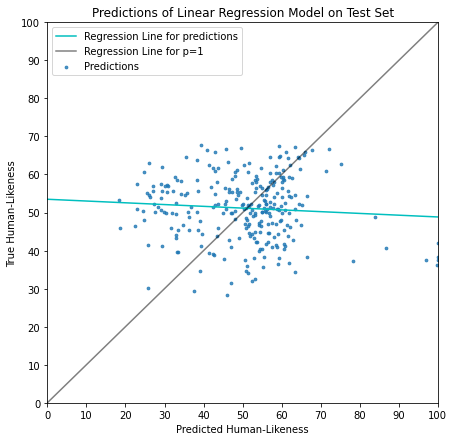

In [30]:
start_time = time.time()
predicted_vs_true('Linear Regression', LinearRegression(), XX, YY, best_duplicates_to_keep, {}, True)
print("Time taken: ", time.time() - start_time)

# Ridge Regression

Tune Dataset Size

Shuffle:  1 / 5  Outer Cond: 1 / 8
Shuffle:  1 / 5  Outer Cond: 2 / 8
Shuffle:  1 / 5  Outer Cond: 3 / 8
Shuffle:  1 / 5  Outer Cond: 4 / 8
Shuffle:  1 / 5  Outer Cond: 5 / 8
Shuffle:  1 / 5  Outer Cond: 6 / 8
Shuffle:  1 / 5  Outer Cond: 7 / 8
Shuffle:  1 / 5  Outer Cond: 8 / 8
Shuffle:  2 / 5  Outer Cond: 1 / 8
Shuffle:  2 / 5  Outer Cond: 2 / 8
Shuffle:  2 / 5  Outer Cond: 3 / 8
Shuffle:  2 / 5  Outer Cond: 4 / 8
Shuffle:  2 / 5  Outer Cond: 5 / 8
Shuffle:  2 / 5  Outer Cond: 6 / 8
Shuffle:  2 / 5  Outer Cond: 7 / 8
Shuffle:  2 / 5  Outer Cond: 8 / 8
Shuffle:  3 / 5  Outer Cond: 1 / 8
Shuffle:  3 / 5  Outer Cond: 2 / 8
Shuffle:  3 / 5  Outer Cond: 3 / 8
Shuffle:  3 / 5  Outer Cond: 4 / 8
Shuffle:  3 / 5  Outer Cond: 5 / 8
Shuffle:  3 / 5  Outer Cond: 6 / 8
Shuffle:  3 / 5  Outer Cond: 7 / 8
Shuffle:  3 / 5  Outer Cond: 8 / 8
Shuffle:  4 / 5  Outer Cond: 1 / 8
Shuffle:  4 / 5  Outer Cond: 2 / 8
Shuffle:  4 / 5  Outer Cond: 3 / 8
Shuffle:  4 / 5  Outer Cond: 4 / 8
Shuffle:  4 / 5  Out

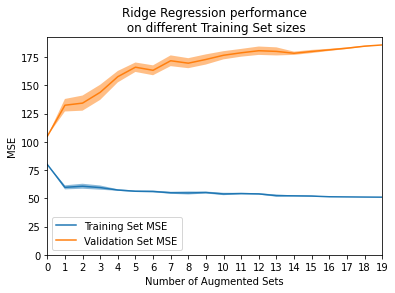

In [68]:
start_time = time.time()
param_grid = {"alpha": np.logspace(-10,10, 10)}
ridge_reg = Ridge()
# 6-fold cv with shuffle=False will hold out one cond on each fold for hyperparemter tuning inside of the learning_curve function
kfolds = KFold(n_splits = 6, shuffle = False)
ridge_model = GridSearchCV(estimator = ridge_reg, param_grid = param_grid, scoring = "neg_mean_squared_error", cv = kfolds) 
best_duplicates_to_keep, best_size = learning_curve('Ridge Regression', ridge_model, XX, YY, True)
print("Time taken: ", time.time() - start_time)

In [31]:
best_duplicates_to_keep = 0

Ridge Regression Hyperparameter Tuning

Outer Fold:  1 / 8  Complete.
Outer Fold:  2 / 8  Complete.
Outer Fold:  3 / 8  Complete.
Outer Fold:  4 / 8  Complete.
Outer Fold:  5 / 8  Complete.
Outer Fold:  6 / 8  Complete.
Outer Fold:  7 / 8  Complete.
Outer Fold:  8 / 8  Complete.
Time taken:  1337.5345242023468


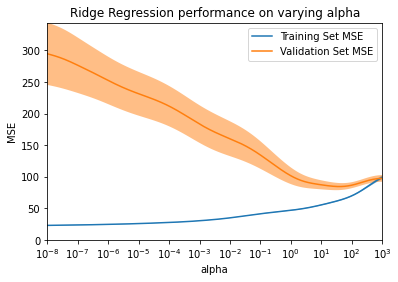

In [32]:
start_time = time.time()
param_grid = {"alpha": np.logspace(-8,3, 1000)}
xticks = np.logspace(-8,3,12)
validation_curve('Ridge Regression', Ridge(), XX, YY, best_duplicates_to_keep, param_grid, True, True, '', xticks)
print("Time taken: ", time.time() - start_time)

Predicted VS True Values on Test Set

Fold  1 /8 Complete
Fold  2 /8 Complete
Fold  3 /8 Complete
Fold  4 /8 Complete
Fold  5 /8 Complete
Fold  6 /8 Complete
Fold  7 /8 Complete
Fold  8 /8 Complete
Pearson Correlation Coefficient = -0.32411919586018395
Mean Squared Error =  99.74477115465629
Train Mean Squared Error =  64.165250910036
Time taken:  315.1220088005066


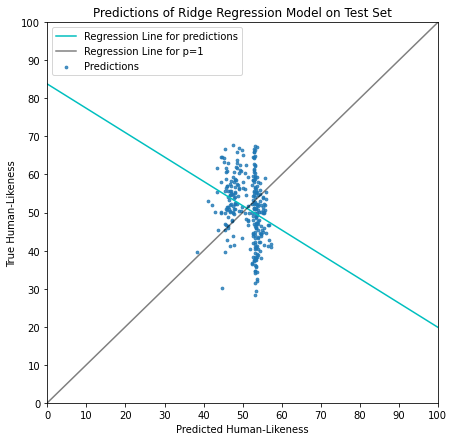

In [34]:
start_time = time.time()
param_grid = {"alpha": np.logspace(-8,3, 1000)}
ridge_model = Ridge()
predicted_vs_true('Ridge Regression', ridge_model, XX, YY, best_duplicates_to_keep, param_grid, True)
print("Time taken: ", time.time() - start_time)

# Kernel Ridge Regression

Tuning Dataset Size

Shuffle:  1 / 5  Outer Cond: 1 / 8
Shuffle:  1 / 5  Outer Cond: 2 / 8
Shuffle:  1 / 5  Outer Cond: 3 / 8
Shuffle:  1 / 5  Outer Cond: 4 / 8
Shuffle:  1 / 5  Outer Cond: 5 / 8
Shuffle:  1 / 5  Outer Cond: 6 / 8
Shuffle:  1 / 5  Outer Cond: 7 / 8
Shuffle:  1 / 5  Outer Cond: 8 / 8
Shuffle:  2 / 5  Outer Cond: 1 / 8
Shuffle:  2 / 5  Outer Cond: 2 / 8
Shuffle:  2 / 5  Outer Cond: 3 / 8
Shuffle:  2 / 5  Outer Cond: 4 / 8
Shuffle:  2 / 5  Outer Cond: 5 / 8
Shuffle:  2 / 5  Outer Cond: 6 / 8
Shuffle:  2 / 5  Outer Cond: 7 / 8
Shuffle:  2 / 5  Outer Cond: 8 / 8
Shuffle:  3 / 5  Outer Cond: 1 / 8
Shuffle:  3 / 5  Outer Cond: 2 / 8
Shuffle:  3 / 5  Outer Cond: 3 / 8
Shuffle:  3 / 5  Outer Cond: 4 / 8
Shuffle:  3 / 5  Outer Cond: 5 / 8
Shuffle:  3 / 5  Outer Cond: 6 / 8
Shuffle:  3 / 5  Outer Cond: 7 / 8
Shuffle:  3 / 5  Outer Cond: 8 / 8
Shuffle:  4 / 5  Outer Cond: 1 / 8
Shuffle:  4 / 5  Outer Cond: 2 / 8
Shuffle:  4 / 5  Outer Cond: 3 / 8
Shuffle:  4 / 5  Outer Cond: 4 / 8
Shuffle:  4 / 5  Out

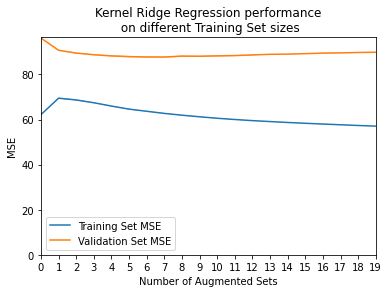

In [69]:
start_time = time.time()
krr = KernelRidge(kernel = "rbf")
# No hyperparameter tuning since it would take far too long
best_duplicates_to_keep, best_size = learning_curve('Kernel Ridge Regression', krr, XX, YY, True)
print("Time taken: ", time.time() - start_time)

In [17]:
best_duplicates_to_keep = 7

Grid Search Cross Validation for Inititalization with Hyperparameter Tuning

In [36]:
start_time = time.time()
modified_XX, modified_YY = reduce_dataset_size(XX, YY, get_rand_studyseqs(best_duplicates_to_keep))
modified_XX_train, modified_YY_train, modified_XX_test, modified_YY_test = split_by_cond(modified_XX, modified_YY, 'Cond_SE')
modified_XX_train, modified_YY_train = modified_XX_train.iloc[:,2:], modified_YY_train.iloc[:,2:] # drop cond and studyseq columns
modified_YY_train = modified_YY_train.values.flatten()

param_grid = {"alpha": np.logspace(-10,5, 16), "gamma": np.logspace(-10, 5, 16)}
# 7 fold with shuffle=False holds one cond out on each inner fold of the predicted_vs_true function
kfolds = KFold(n_splits = 7, shuffle = False)
krr = GridSearchCV(estimator = KernelRidge(kernel = "rbf"), param_grid = param_grid, scoring = "neg_mean_squared_error", cv=kfolds, verbose = 3)
krr.fit(modified_XX_train, modified_YY_train)

krr_init_params = krr.best_params_
print("Time taken: ", time.time() - start_time)

Fitting 7 folds for each of 256 candidates, totalling 1792 fits
[CV 1/7] END .......................alpha=1e-10, gamma=1e-10; total time=   0.2s
[CV 2/7] END .......................alpha=1e-10, gamma=1e-10; total time=   0.2s
[CV 3/7] END .......................alpha=1e-10, gamma=1e-10; total time=   0.2s
[CV 4/7] END .......................alpha=1e-10, gamma=1e-10; total time=   0.2s
[CV 5/7] END .......................alpha=1e-10, gamma=1e-10; total time=   0.1s
[CV 6/7] END .......................alpha=1e-10, gamma=1e-10; total time=   0.1s
[CV 7/7] END .......................alpha=1e-10, gamma=1e-10; total time=   0.1s
[CV 1/7] END .......................alpha=1e-10, gamma=1e-09; total time=   0.2s
[CV 2/7] END .......................alpha=1e-10, gamma=1e-09; total time=   0.2s
[CV 3/7] END .......................alpha=1e-10, gamma=1e-09; total time=   0.1s
[CV 4/7] END .......................alpha=1e-10, gamma=1e-09; total time=   0.1s
[CV 5/7] END .......................alpha=1e-

[CV 4/7] END .....................alpha=1e-10, gamma=10000.0; total time=   0.3s
[CV 5/7] END .....................alpha=1e-10, gamma=10000.0; total time=   0.3s
[CV 6/7] END .....................alpha=1e-10, gamma=10000.0; total time=   0.3s
[CV 7/7] END .....................alpha=1e-10, gamma=10000.0; total time=   0.3s
[CV 1/7] END ....................alpha=1e-10, gamma=100000.0; total time=   0.3s
[CV 2/7] END ....................alpha=1e-10, gamma=100000.0; total time=   0.3s
[CV 3/7] END ....................alpha=1e-10, gamma=100000.0; total time=   0.3s
[CV 4/7] END ....................alpha=1e-10, gamma=100000.0; total time=   0.3s
[CV 5/7] END ....................alpha=1e-10, gamma=100000.0; total time=   0.3s
[CV 6/7] END ....................alpha=1e-10, gamma=100000.0; total time=   0.3s
[CV 7/7] END ....................alpha=1e-10, gamma=100000.0; total time=   0.3s
[CV 1/7] END .......................alpha=1e-09, gamma=1e-10; total time=   0.1s
[CV 2/7] END ...............

[CV 1/7] END ......................alpha=1e-09, gamma=1000.0; total time=   0.3s
[CV 2/7] END ......................alpha=1e-09, gamma=1000.0; total time=   0.3s
[CV 3/7] END ......................alpha=1e-09, gamma=1000.0; total time=   0.3s
[CV 4/7] END ......................alpha=1e-09, gamma=1000.0; total time=   0.3s
[CV 5/7] END ......................alpha=1e-09, gamma=1000.0; total time=   0.3s
[CV 6/7] END ......................alpha=1e-09, gamma=1000.0; total time=   0.3s
[CV 7/7] END ......................alpha=1e-09, gamma=1000.0; total time=   0.3s
[CV 1/7] END .....................alpha=1e-09, gamma=10000.0; total time=   0.3s
[CV 2/7] END .....................alpha=1e-09, gamma=10000.0; total time=   0.3s
[CV 3/7] END .....................alpha=1e-09, gamma=10000.0; total time=   0.3s
[CV 4/7] END .....................alpha=1e-09, gamma=10000.0; total time=   0.3s
[CV 5/7] END .....................alpha=1e-09, gamma=10000.0; total time=   0.3s
[CV 6/7] END ...............

[CV 5/7] END ........................alpha=1e-08, gamma=10.0; total time=   0.1s
[CV 6/7] END ........................alpha=1e-08, gamma=10.0; total time=   0.1s
[CV 7/7] END ........................alpha=1e-08, gamma=10.0; total time=   0.1s
[CV 1/7] END .......................alpha=1e-08, gamma=100.0; total time=   0.6s
[CV 2/7] END .......................alpha=1e-08, gamma=100.0; total time=   0.6s
[CV 3/7] END .......................alpha=1e-08, gamma=100.0; total time=   0.6s
[CV 4/7] END .......................alpha=1e-08, gamma=100.0; total time=   0.6s
[CV 5/7] END .......................alpha=1e-08, gamma=100.0; total time=   0.5s
[CV 6/7] END .......................alpha=1e-08, gamma=100.0; total time=   0.6s
[CV 7/7] END .......................alpha=1e-08, gamma=100.0; total time=   0.6s
[CV 1/7] END ......................alpha=1e-08, gamma=1000.0; total time=   0.3s
[CV 2/7] END ......................alpha=1e-08, gamma=1000.0; total time=   0.3s
[CV 3/7] END ...............

[CV 3/7] END .........................alpha=1e-07, gamma=1.0; total time=   0.1s
[CV 4/7] END .........................alpha=1e-07, gamma=1.0; total time=   0.1s
[CV 5/7] END .........................alpha=1e-07, gamma=1.0; total time=   0.1s
[CV 6/7] END .........................alpha=1e-07, gamma=1.0; total time=   0.1s
[CV 7/7] END .........................alpha=1e-07, gamma=1.0; total time=   0.1s
[CV 1/7] END ........................alpha=1e-07, gamma=10.0; total time=   0.1s
[CV 2/7] END ........................alpha=1e-07, gamma=10.0; total time=   0.1s
[CV 3/7] END ........................alpha=1e-07, gamma=10.0; total time=   0.1s
[CV 4/7] END ........................alpha=1e-07, gamma=10.0; total time=   0.1s
[CV 5/7] END ........................alpha=1e-07, gamma=10.0; total time=   0.2s
[CV 6/7] END ........................alpha=1e-07, gamma=10.0; total time=   0.1s
[CV 7/7] END ........................alpha=1e-07, gamma=10.0; total time=   0.2s
[CV 1/7] END ...............

[CV 7/7] END ........................alpha=1e-06, gamma=0.01; total time=   0.2s
[CV 1/7] END .........................alpha=1e-06, gamma=0.1; total time=   0.2s
[CV 2/7] END .........................alpha=1e-06, gamma=0.1; total time=   0.3s
[CV 3/7] END .........................alpha=1e-06, gamma=0.1; total time=   0.2s
[CV 4/7] END .........................alpha=1e-06, gamma=0.1; total time=   0.2s
[CV 5/7] END .........................alpha=1e-06, gamma=0.1; total time=   0.2s
[CV 6/7] END .........................alpha=1e-06, gamma=0.1; total time=   0.2s
[CV 7/7] END .........................alpha=1e-06, gamma=0.1; total time=   0.2s
[CV 1/7] END .........................alpha=1e-06, gamma=1.0; total time=   0.3s
[CV 2/7] END .........................alpha=1e-06, gamma=1.0; total time=   0.2s
[CV 3/7] END .........................alpha=1e-06, gamma=1.0; total time=   0.2s
[CV 4/7] END .........................alpha=1e-06, gamma=1.0; total time=   0.2s
[CV 5/7] END ...............

[CV 4/7] END .......................alpha=1e-05, gamma=0.001; total time=   0.2s
[CV 5/7] END .......................alpha=1e-05, gamma=0.001; total time=   0.2s
[CV 6/7] END .......................alpha=1e-05, gamma=0.001; total time=   0.2s
[CV 7/7] END .......................alpha=1e-05, gamma=0.001; total time=   0.2s
[CV 1/7] END ........................alpha=1e-05, gamma=0.01; total time=   0.2s
[CV 2/7] END ........................alpha=1e-05, gamma=0.01; total time=   0.2s
[CV 3/7] END ........................alpha=1e-05, gamma=0.01; total time=   0.2s
[CV 4/7] END ........................alpha=1e-05, gamma=0.01; total time=   0.2s
[CV 5/7] END ........................alpha=1e-05, gamma=0.01; total time=   0.2s
[CV 6/7] END ........................alpha=1e-05, gamma=0.01; total time=   0.3s
[CV 7/7] END ........................alpha=1e-05, gamma=0.01; total time=   0.2s
[CV 1/7] END .........................alpha=1e-05, gamma=0.1; total time=   0.2s
[CV 2/7] END ...............

[CV 1/7] END .....................alpha=0.0001, gamma=0.0001; total time=   0.2s
[CV 2/7] END .....................alpha=0.0001, gamma=0.0001; total time=   0.2s
[CV 3/7] END .....................alpha=0.0001, gamma=0.0001; total time=   0.2s
[CV 4/7] END .....................alpha=0.0001, gamma=0.0001; total time=   0.2s
[CV 5/7] END .....................alpha=0.0001, gamma=0.0001; total time=   0.2s
[CV 6/7] END .....................alpha=0.0001, gamma=0.0001; total time=   0.2s
[CV 7/7] END .....................alpha=0.0001, gamma=0.0001; total time=   0.1s
[CV 1/7] END ......................alpha=0.0001, gamma=0.001; total time=   0.3s
[CV 2/7] END ......................alpha=0.0001, gamma=0.001; total time=   0.4s
[CV 3/7] END ......................alpha=0.0001, gamma=0.001; total time=   0.4s
[CV 4/7] END ......................alpha=0.0001, gamma=0.001; total time=   0.4s
[CV 5/7] END ......................alpha=0.0001, gamma=0.001; total time=   0.5s
[CV 6/7] END ...............

[CV 5/7] END .......................alpha=0.001, gamma=1e-06; total time=   0.2s
[CV 6/7] END .......................alpha=0.001, gamma=1e-06; total time=   0.1s
[CV 7/7] END .......................alpha=0.001, gamma=1e-06; total time=   0.1s
[CV 1/7] END .......................alpha=0.001, gamma=1e-05; total time=   0.1s
[CV 2/7] END .......................alpha=0.001, gamma=1e-05; total time=   0.1s
[CV 3/7] END .......................alpha=0.001, gamma=1e-05; total time=   0.2s
[CV 4/7] END .......................alpha=0.001, gamma=1e-05; total time=   0.2s
[CV 5/7] END .......................alpha=0.001, gamma=1e-05; total time=   0.2s
[CV 6/7] END .......................alpha=0.001, gamma=1e-05; total time=   0.1s
[CV 7/7] END .......................alpha=0.001, gamma=1e-05; total time=   0.1s
[CV 1/7] END ......................alpha=0.001, gamma=0.0001; total time=   0.1s
[CV 2/7] END ......................alpha=0.001, gamma=0.0001; total time=   0.1s
[CV 3/7] END ...............

[CV 2/7] END ........................alpha=0.01, gamma=1e-07; total time=   0.2s
[CV 3/7] END ........................alpha=0.01, gamma=1e-07; total time=   0.1s
[CV 4/7] END ........................alpha=0.01, gamma=1e-07; total time=   0.1s
[CV 5/7] END ........................alpha=0.01, gamma=1e-07; total time=   0.1s
[CV 6/7] END ........................alpha=0.01, gamma=1e-07; total time=   0.1s
[CV 7/7] END ........................alpha=0.01, gamma=1e-07; total time=   0.1s
[CV 1/7] END ........................alpha=0.01, gamma=1e-06; total time=   0.1s
[CV 2/7] END ........................alpha=0.01, gamma=1e-06; total time=   0.1s
[CV 3/7] END ........................alpha=0.01, gamma=1e-06; total time=   0.1s
[CV 4/7] END ........................alpha=0.01, gamma=1e-06; total time=   0.1s
[CV 5/7] END ........................alpha=0.01, gamma=1e-06; total time=   0.1s
[CV 6/7] END ........................alpha=0.01, gamma=1e-06; total time=   0.1s
[CV 7/7] END ...............

[CV 6/7] END .........................alpha=0.1, gamma=1e-09; total time=   0.1s
[CV 7/7] END .........................alpha=0.1, gamma=1e-09; total time=   0.1s
[CV 1/7] END .........................alpha=0.1, gamma=1e-08; total time=   0.1s
[CV 2/7] END .........................alpha=0.1, gamma=1e-08; total time=   0.1s
[CV 3/7] END .........................alpha=0.1, gamma=1e-08; total time=   0.1s
[CV 4/7] END .........................alpha=0.1, gamma=1e-08; total time=   0.1s
[CV 5/7] END .........................alpha=0.1, gamma=1e-08; total time=   0.1s
[CV 6/7] END .........................alpha=0.1, gamma=1e-08; total time=   0.1s
[CV 7/7] END .........................alpha=0.1, gamma=1e-08; total time=   0.1s
[CV 1/7] END .........................alpha=0.1, gamma=1e-07; total time=   0.1s
[CV 2/7] END .........................alpha=0.1, gamma=1e-07; total time=   0.1s
[CV 3/7] END .........................alpha=0.1, gamma=1e-07; total time=   0.1s
[CV 4/7] END ...............

[CV 3/7] END .........................alpha=1.0, gamma=1e-10; total time=   0.1s
[CV 4/7] END .........................alpha=1.0, gamma=1e-10; total time=   0.1s
[CV 5/7] END .........................alpha=1.0, gamma=1e-10; total time=   0.1s
[CV 6/7] END .........................alpha=1.0, gamma=1e-10; total time=   0.1s
[CV 7/7] END .........................alpha=1.0, gamma=1e-10; total time=   0.1s
[CV 1/7] END .........................alpha=1.0, gamma=1e-09; total time=   0.1s
[CV 2/7] END .........................alpha=1.0, gamma=1e-09; total time=   0.1s
[CV 3/7] END .........................alpha=1.0, gamma=1e-09; total time=   0.1s
[CV 4/7] END .........................alpha=1.0, gamma=1e-09; total time=   0.1s
[CV 5/7] END .........................alpha=1.0, gamma=1e-09; total time=   0.1s
[CV 6/7] END .........................alpha=1.0, gamma=1e-09; total time=   0.1s
[CV 7/7] END .........................alpha=1.0, gamma=1e-09; total time=   0.1s
[CV 1/7] END ...............

[CV 7/7] END .......................alpha=1.0, gamma=10000.0; total time=   0.3s
[CV 1/7] END ......................alpha=1.0, gamma=100000.0; total time=   0.3s
[CV 2/7] END ......................alpha=1.0, gamma=100000.0; total time=   0.3s
[CV 3/7] END ......................alpha=1.0, gamma=100000.0; total time=   0.3s
[CV 4/7] END ......................alpha=1.0, gamma=100000.0; total time=   0.3s
[CV 5/7] END ......................alpha=1.0, gamma=100000.0; total time=   0.3s
[CV 6/7] END ......................alpha=1.0, gamma=100000.0; total time=   0.3s
[CV 7/7] END ......................alpha=1.0, gamma=100000.0; total time=   0.3s
[CV 1/7] END ........................alpha=10.0, gamma=1e-10; total time=   0.1s
[CV 2/7] END ........................alpha=10.0, gamma=1e-10; total time=   0.1s
[CV 3/7] END ........................alpha=10.0, gamma=1e-10; total time=   0.1s
[CV 4/7] END ........................alpha=10.0, gamma=1e-10; total time=   0.1s
[CV 5/7] END ...............

[CV 4/7] END .......................alpha=10.0, gamma=1000.0; total time=   0.4s
[CV 5/7] END .......................alpha=10.0, gamma=1000.0; total time=   0.4s
[CV 6/7] END .......................alpha=10.0, gamma=1000.0; total time=   0.3s
[CV 7/7] END .......................alpha=10.0, gamma=1000.0; total time=   0.3s
[CV 1/7] END ......................alpha=10.0, gamma=10000.0; total time=   0.3s
[CV 2/7] END ......................alpha=10.0, gamma=10000.0; total time=   0.3s
[CV 3/7] END ......................alpha=10.0, gamma=10000.0; total time=   0.3s
[CV 4/7] END ......................alpha=10.0, gamma=10000.0; total time=   0.3s
[CV 5/7] END ......................alpha=10.0, gamma=10000.0; total time=   0.3s
[CV 6/7] END ......................alpha=10.0, gamma=10000.0; total time=   0.3s
[CV 7/7] END ......................alpha=10.0, gamma=10000.0; total time=   0.3s
[CV 1/7] END .....................alpha=10.0, gamma=100000.0; total time=   0.3s
[CV 2/7] END ...............

[CV 1/7] END .......................alpha=100.0, gamma=100.0; total time=   0.7s
[CV 2/7] END .......................alpha=100.0, gamma=100.0; total time=   0.7s
[CV 3/7] END .......................alpha=100.0, gamma=100.0; total time=   0.6s
[CV 4/7] END .......................alpha=100.0, gamma=100.0; total time=   0.6s
[CV 5/7] END .......................alpha=100.0, gamma=100.0; total time=   0.6s
[CV 6/7] END .......................alpha=100.0, gamma=100.0; total time=   0.8s
[CV 7/7] END .......................alpha=100.0, gamma=100.0; total time=   0.7s
[CV 1/7] END ......................alpha=100.0, gamma=1000.0; total time=   0.4s
[CV 2/7] END ......................alpha=100.0, gamma=1000.0; total time=   0.3s
[CV 3/7] END ......................alpha=100.0, gamma=1000.0; total time=   0.3s
[CV 4/7] END ......................alpha=100.0, gamma=1000.0; total time=   0.3s
[CV 5/7] END ......................alpha=100.0, gamma=1000.0; total time=   0.4s
[CV 6/7] END ...............

[CV 5/7] END ........................alpha=1000.0, gamma=1.0; total time=   0.1s
[CV 6/7] END ........................alpha=1000.0, gamma=1.0; total time=   0.1s
[CV 7/7] END ........................alpha=1000.0, gamma=1.0; total time=   0.1s
[CV 1/7] END .......................alpha=1000.0, gamma=10.0; total time=   0.2s
[CV 2/7] END .......................alpha=1000.0, gamma=10.0; total time=   0.3s
[CV 3/7] END .......................alpha=1000.0, gamma=10.0; total time=   0.3s
[CV 4/7] END .......................alpha=1000.0, gamma=10.0; total time=   0.5s
[CV 5/7] END .......................alpha=1000.0, gamma=10.0; total time=   0.3s
[CV 6/7] END .......................alpha=1000.0, gamma=10.0; total time=   0.3s
[CV 7/7] END .......................alpha=1000.0, gamma=10.0; total time=   0.3s
[CV 1/7] END ......................alpha=1000.0, gamma=100.0; total time=   1.0s
[CV 2/7] END ......................alpha=1000.0, gamma=100.0; total time=   0.9s
[CV 3/7] END ...............

[CV 2/7] END .......................alpha=10000.0, gamma=0.1; total time=   0.2s
[CV 3/7] END .......................alpha=10000.0, gamma=0.1; total time=   0.2s
[CV 4/7] END .......................alpha=10000.0, gamma=0.1; total time=   0.2s
[CV 5/7] END .......................alpha=10000.0, gamma=0.1; total time=   0.2s
[CV 6/7] END .......................alpha=10000.0, gamma=0.1; total time=   0.2s
[CV 7/7] END .......................alpha=10000.0, gamma=0.1; total time=   0.4s
[CV 1/7] END .......................alpha=10000.0, gamma=1.0; total time=   0.2s
[CV 2/7] END .......................alpha=10000.0, gamma=1.0; total time=   0.2s
[CV 3/7] END .......................alpha=10000.0, gamma=1.0; total time=   0.3s
[CV 4/7] END .......................alpha=10000.0, gamma=1.0; total time=   0.2s
[CV 5/7] END .......................alpha=10000.0, gamma=1.0; total time=   0.2s
[CV 6/7] END .......................alpha=10000.0, gamma=1.0; total time=   0.2s
[CV 7/7] END ...............

[CV 6/7] END ....................alpha=100000.0, gamma=0.001; total time=   0.2s
[CV 7/7] END ....................alpha=100000.0, gamma=0.001; total time=   0.3s
[CV 1/7] END .....................alpha=100000.0, gamma=0.01; total time=   0.3s
[CV 2/7] END .....................alpha=100000.0, gamma=0.01; total time=   0.3s
[CV 3/7] END .....................alpha=100000.0, gamma=0.01; total time=   0.4s
[CV 4/7] END .....................alpha=100000.0, gamma=0.01; total time=   0.2s
[CV 5/7] END .....................alpha=100000.0, gamma=0.01; total time=   0.3s
[CV 6/7] END .....................alpha=100000.0, gamma=0.01; total time=   0.2s
[CV 7/7] END .....................alpha=100000.0, gamma=0.01; total time=   0.2s
[CV 1/7] END ......................alpha=100000.0, gamma=0.1; total time=   0.3s
[CV 2/7] END ......................alpha=100000.0, gamma=0.1; total time=   0.3s
[CV 3/7] END ......................alpha=100000.0, gamma=0.1; total time=   0.2s
[CV 4/7] END ...............

In [37]:
print(krr_init_params)

{'alpha': 1e-07, 'gamma': 1e-09}


Tuning Alpha

Outer Fold:  1 / 8  Complete.
Outer Fold:  2 / 8  Complete.
Outer Fold:  3 / 8  Complete.
Outer Fold:  4 / 8  Complete.
Outer Fold:  5 / 8  Complete.
Outer Fold:  6 / 8  Complete.
Outer Fold:  7 / 8  Complete.
Outer Fold:  8 / 8  Complete.
Time taken:  433.4130551815033


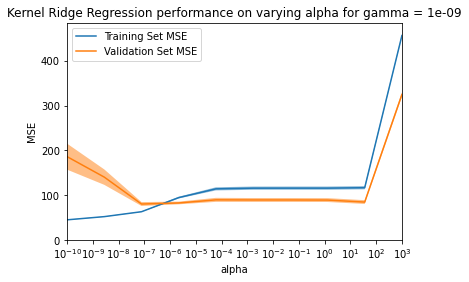

In [38]:
start_time = time.time()
krr = KernelRidge(kernel = "rbf", gamma = krr_init_params['gamma'])
extra_string = ' for gamma = ' + str(krr_init_params['gamma'])
param_grid = {"alpha": np.logspace(-10,3, 10)}
xticks = np.logspace(-10,3, 14)
validation_curve('Kernel Ridge Regression', krr, XX, YY, best_duplicates_to_keep, param_grid, True, True, extra_string, xticks)
print("Time taken: ", time.time() - start_time)

Tuning Gamma

Outer Fold:  1 / 8  Complete.
Outer Fold:  2 / 8  Complete.
Outer Fold:  3 / 8  Complete.
Outer Fold:  4 / 8  Complete.
Outer Fold:  5 / 8  Complete.
Outer Fold:  6 / 8  Complete.
Outer Fold:  7 / 8  Complete.
Outer Fold:  8 / 8  Complete.
Time taken:  489.3961970806122


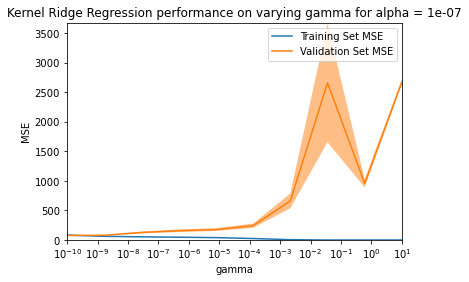

In [39]:
start_time = time.time()
krr = KernelRidge(kernel = "rbf", alpha = krr_init_params['alpha'])
extra_string = ' for alpha = ' + str(krr_init_params['alpha'])
param_grid = {"gamma": np.logspace(-10, 1, 10)}
xticks = np.logspace(-10,1, 12)
validation_curve('Kernel Ridge Regression', krr, XX, YY, best_duplicates_to_keep, param_grid, True, True, extra_string, xticks)
print("Time taken: ", time.time() - start_time)

Graph of Predicted VS True Values on Test Set

Fold  1 /8 Complete
Fold  2 /8 Complete
Fold  3 /8 Complete
Fold  4 /8 Complete
Fold  5 /8 Complete
Fold  6 /8 Complete
Fold  7 /8 Complete
Fold  8 /8 Complete
Pearson Correlation Coefficient = -0.3879867720508808
Mean Squared Error =  117.77188070090217
Train Mean Squared Error =  78.9767521137931
Time taken:  1212.4041111469269


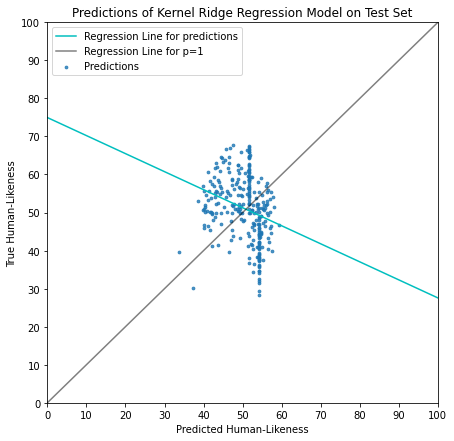

In [18]:
start_time = time.time()
krr_model = KernelRidge(kernel = "rbf")
param_grid = {"alpha": np.logspace(-10,3, 10), "gamma": np.logspace(-10, 1, 10)}
predicted_vs_true('Kernel Ridge Regression', krr_model, XX, YY, best_duplicates_to_keep, param_grid, True)
print("Time taken: ", time.time() - start_time)

# kNN Regression

Tune Dataset Size

Shuffle:  1 / 5  Outer Cond: 1 / 8
Shuffle:  1 / 5  Outer Cond: 2 / 8
Shuffle:  1 / 5  Outer Cond: 3 / 8
Shuffle:  1 / 5  Outer Cond: 4 / 8
Shuffle:  1 / 5  Outer Cond: 5 / 8
Shuffle:  1 / 5  Outer Cond: 6 / 8
Shuffle:  1 / 5  Outer Cond: 7 / 8
Shuffle:  1 / 5  Outer Cond: 8 / 8
Shuffle:  2 / 5  Outer Cond: 1 / 8
Shuffle:  2 / 5  Outer Cond: 2 / 8
Shuffle:  2 / 5  Outer Cond: 3 / 8
Shuffle:  2 / 5  Outer Cond: 4 / 8
Shuffle:  2 / 5  Outer Cond: 5 / 8
Shuffle:  2 / 5  Outer Cond: 6 / 8
Shuffle:  2 / 5  Outer Cond: 7 / 8
Shuffle:  2 / 5  Outer Cond: 8 / 8
Shuffle:  3 / 5  Outer Cond: 1 / 8
Shuffle:  3 / 5  Outer Cond: 2 / 8
Shuffle:  3 / 5  Outer Cond: 3 / 8
Shuffle:  3 / 5  Outer Cond: 4 / 8
Shuffle:  3 / 5  Outer Cond: 5 / 8
Shuffle:  3 / 5  Outer Cond: 6 / 8
Shuffle:  3 / 5  Outer Cond: 7 / 8
Shuffle:  3 / 5  Outer Cond: 8 / 8
Shuffle:  4 / 5  Outer Cond: 1 / 8
Shuffle:  4 / 5  Outer Cond: 2 / 8
Shuffle:  4 / 5  Outer Cond: 3 / 8
Shuffle:  4 / 5  Outer Cond: 4 / 8
Shuffle:  4 / 5  Out

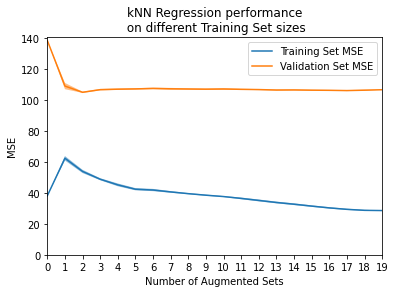

In [70]:
start_time = time.time()
# 6-fold cv with shuffle=False will hold out one cond on each fold for hyperparemter tuning inside of the learning_curve function
kfolds = KFold(n_splits = 6, shuffle = False)
param_grid = {"n_neighbors": np.arange(1,41,5)}
knn = KNeighborsRegressor()
knn_model = GridSearchCV(estimator = knn, param_grid = param_grid, scoring = "neg_mean_squared_error", cv = kfolds)
best_duplicates_to_keep, best_size = learning_curve('kNN Regression', knn_model, XX, YY, True)
print("Time taken: ", time.time() - start_time)

In [19]:
best_duplicates_to_keep = 2

Tune n_neighbors for weights = uniform

Outer Fold:  1 / 8  Complete.
Outer Fold:  2 / 8  Complete.
Outer Fold:  3 / 8  Complete.
Outer Fold:  4 / 8  Complete.
Outer Fold:  5 / 8  Complete.
Outer Fold:  6 / 8  Complete.
Outer Fold:  7 / 8  Complete.
Outer Fold:  8 / 8  Complete.
Time taken:  146.75580143928528


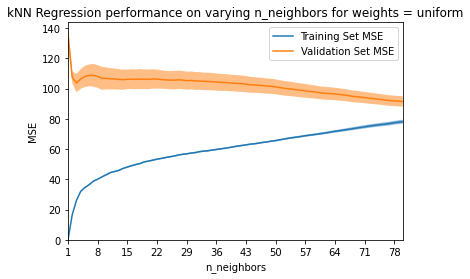

In [24]:
start_time = time.time()
knn = KNeighborsRegressor(weights = 'uniform')
extra_string = ' for weights = uniform'
param_grid = {"n_neighbors": np.arange(1,81,1)}
xticks = np.arange(1,81,7)
validation_curve('kNN Regression', knn, XX, YY, best_duplicates_to_keep, param_grid, False, True, extra_string, xticks)
print("Time taken: ", time.time() - start_time)

Tune n_neighbors for weights = distance

Outer Fold:  1 / 8  Complete.
Outer Fold:  2 / 8  Complete.
Outer Fold:  3 / 8  Complete.
Outer Fold:  4 / 8  Complete.
Outer Fold:  5 / 8  Complete.
Outer Fold:  6 / 8  Complete.
Outer Fold:  7 / 8  Complete.
Outer Fold:  8 / 8  Complete.
Time taken:  158.82183051109314


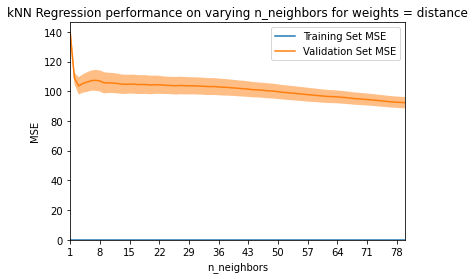

In [25]:
start_time = time.time()
knn = KNeighborsRegressor(weights = 'distance')
extra_string = ' for weights = distance'
param_grid = {"n_neighbors": np.arange(1,81,1)}
xticks = np.arange(1,81,7)
validation_curve('kNN Regression', knn, XX, YY, best_duplicates_to_keep, param_grid, False, True, extra_string, xticks)
print("Time taken: ", time.time() - start_time)

Predicted VS True

Fold  1 /8 Complete
Fold  2 /8 Complete
Fold  3 /8 Complete
Fold  4 /8 Complete
Fold  5 /8 Complete
Fold  6 /8 Complete
Fold  7 /8 Complete
Fold  8 /8 Complete
Pearson Correlation Coefficient = -0.20448491875488783
Mean Squared Error =  103.78545323996705
Train Mean Squared Error =  20.324420205558813
Time taken:  88.29413938522339


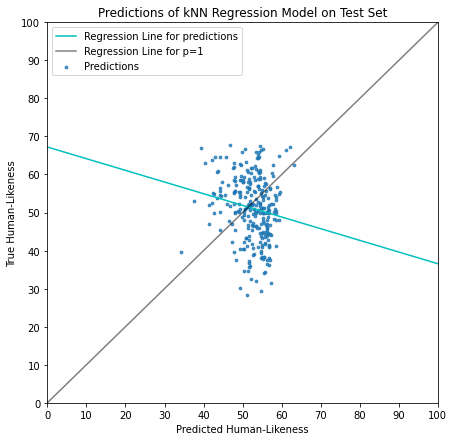

In [27]:
start_time = time.time()
param_grid = {"n_neighbors": np.arange(1,81,1), "weights": ["uniform", "distance"]}
knn = KNeighborsRegressor()
predicted_vs_true('kNN Regression', knn, XX, YY, best_duplicates_to_keep, param_grid, True)
print("Time taken: ", time.time() - start_time)

# Train vs Test MSEs

In [ ]:
# SVR
print("SVR Train MSE: ", mean_squared_error(YY_train, svr.best_estimator_.predict(XX_train)))
print("SVR Test MSE: ", mean_squared_error(YY_test, svr.best_estimator_.predict(XX_test)))

# Linear Regression
print("Linear Regression Train MSE: ", mean_squared_error(YY_train,lr.predict(XX_train)))
print("Linear Regression Test MSE: ", mean_squared_error(YY_test, lr.predict(XX_test)))

# Ridge Regression
print("Ridge Regression Train MSE: ", mean_squared_error(YY_train, ridge_model.best_estimator_.predict(XX_train)))
print("Ridge Regression Test MSE: ", mean_squared_error(YY_test, ridge_model.best_estimator_.predict(XX_test)))

# Kernel Ridge Regression
print("Kernel Ridge Regression Train MSE: ", mean_squared_error(YY_train, krr_model.best_estimator_.predict(XX_train)))
print("Kernel Ridge Regression Test MSE: ", mean_squared_error(YY_test, krr_model.best_estimator_.predict(XX_test)))

# kNN Regression
print("KNN Regression Train MSE: ", mean_squared_error(YY_train, knn_model.best_estimator_.predict(XX_train)))
print("KNN Regression Test MSE: ", mean_squared_error(YY_test, knn_model.best_estimator_.predict(XX_test)))

In [ ]:
knn_model.best_params_